In [ ]:
#Studying a piece of land and analyzing the geography

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

Matplotlib created a temporary config/cache directory at /var/folders/zf/49prmn_s7s5861rytkmr3_080000gn/T/matplotlib-g4vhmi0q because the default path (/Users/ribells/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


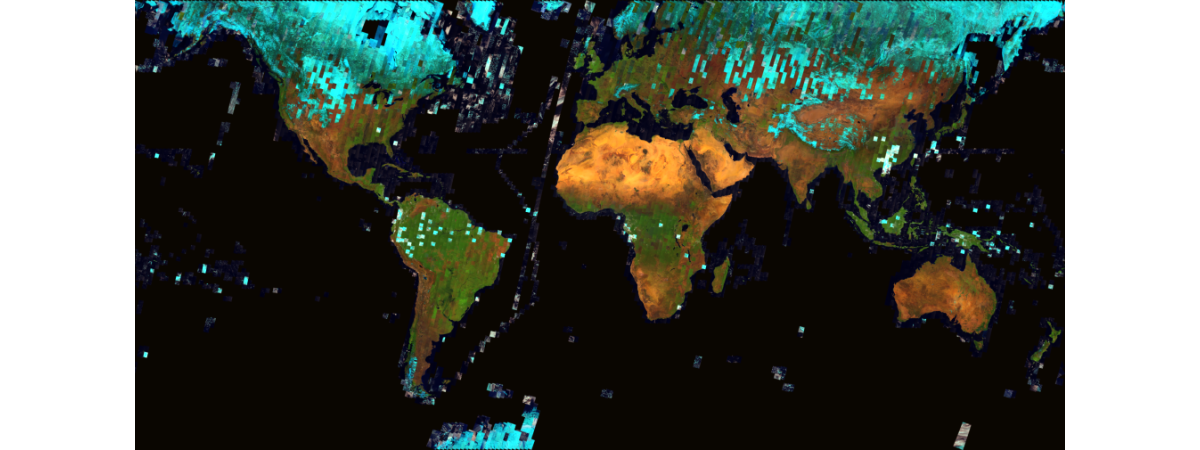

In [33]:
#gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123')
gis = GIS()

arcgis.raster.analytics.is_supported(gis)

search_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = search_item.layers[0]

landsat

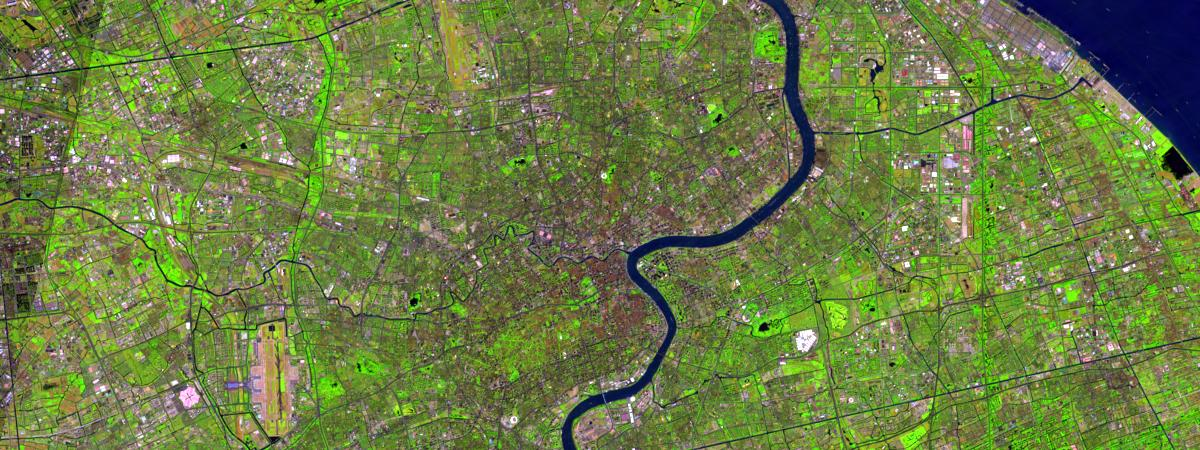

In [34]:
from arcgis.geocoding import geocode

extent = geocode("Shanghai, China", out_sr=landsat.properties.spatialReference)[1]
landsat.extent = extent['extent']
landsat

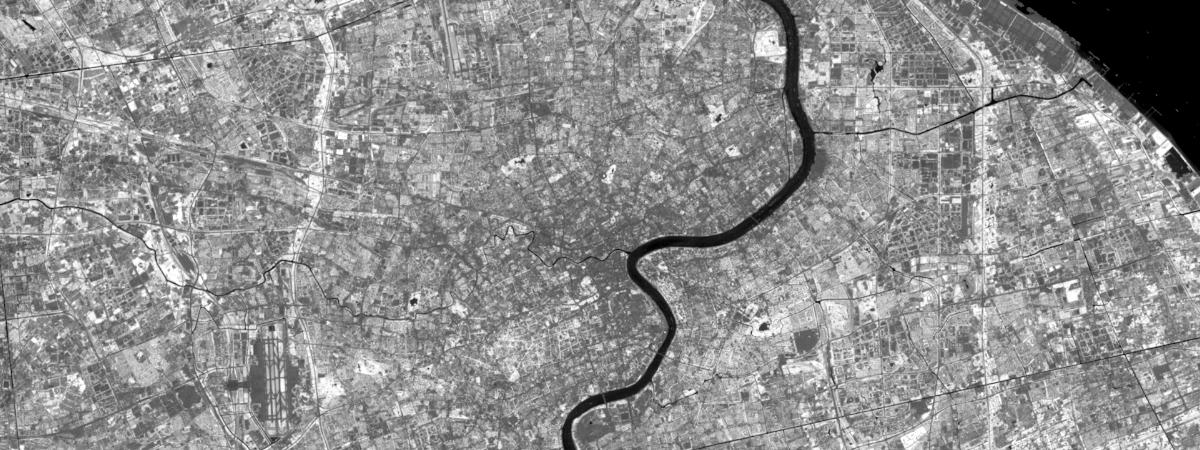

In [35]:
ndvi_colorized = apply(landsat, 'NDVI Raw')
ndvi_colorized

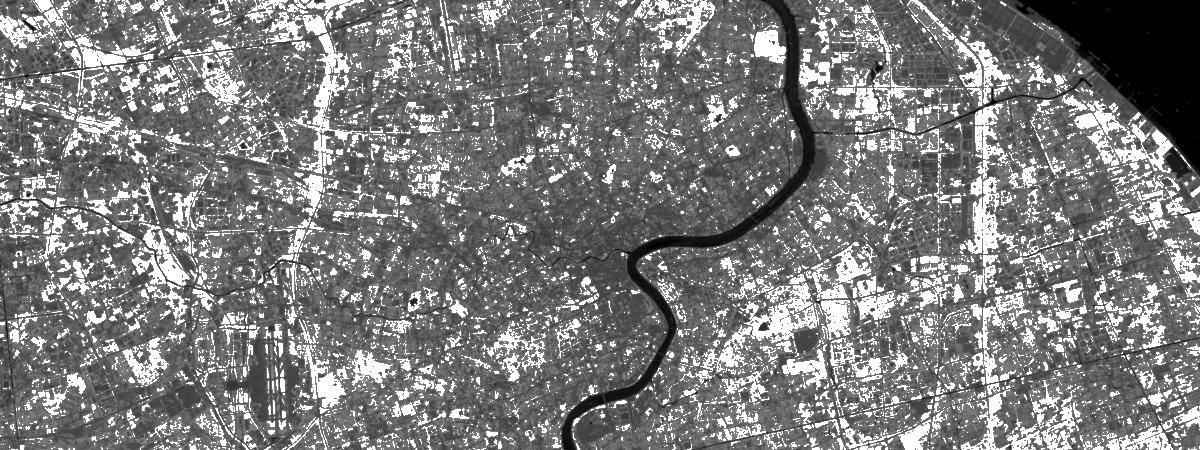

In [36]:
threshold_value = 0.45
extent_new = remap(ndvi_colorized,[0.4,threshold_value,threshold_value, 1], [1, 2])
extent_new

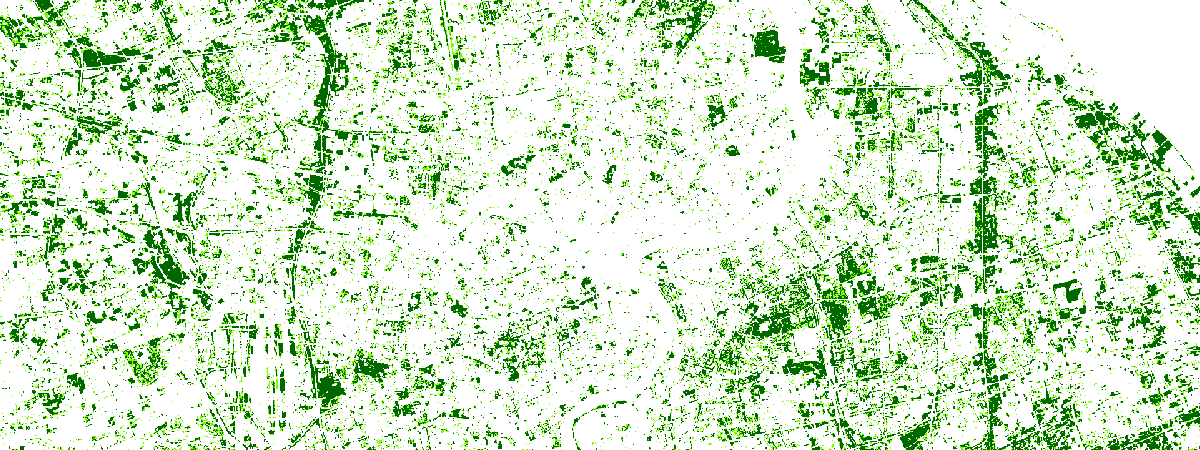

In [37]:
extent_colored = colormap(extent_new,'',colormap=[[1, 124, 252, 0], [2, 0, 102, 0]])
extent_colored

{'histograms': [{'size': 3, 'min': -0.5, 'max': 2.5, 'counts': [9416120, 658055, 1023065]}]}


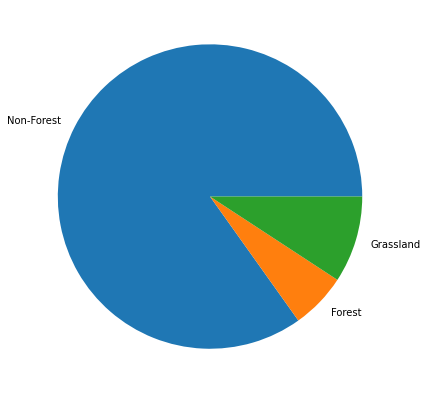

{'histograms': [{'size': 3, 'min': -0.5, 'max': 2.5, 'counts': [9416120, 658055, 1023065]}]}


In [38]:
import matplotlib.pyplot as plt
pix_x = 6
pix_y = 6
res = extent_colored.compute_histograms(extent_colored.extent, pixel_size={'x':pix_x, 'y':pix_y})
numpix = 0
histogram = res['histograms'][0]['counts'][0:]
print(res)

extent_area = ['Non-Forest', 'Forest', 'Grassland']
data = res['histograms'][0]['counts'][0:]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = ['Non-Forest', 'Forest', 'Grassland'])
plt.show()

print(res)

In [57]:
# Provide ability to add forest or remove forest from the starting point 
# and capture the keyboard and mouse use of the user

from tkinter import *
from tkinter.filedialog import *
from PIL import Image, ImageTk
import numpy as np

# --- functions ---

w = 6 # change brush size
a = 0 # index for color
paints_list=[]
color_list = ["white", "green"]

def change_color():
    global a
    a = (a + 1) % 2  
    
def savefile():
    # Download Ghostscript: https://www.ghostscript.com/releases/gsdnld.html
    # add GhostScript to Path
    canvas.postscript(file="UserForest.eps")
    #img = Image.open("UserForest.eps")
    #img.save("UserForest.png", lossless=True)

def clear_all():
    """clearing all user inputs"""
    for i in range(len(paints_list)):
        canvas.delete(paints_list[i])
        
    with open("UserRecord.txt", 'w+') as f:
        f.truncate(0)
        
def on_click(event):
    global lastx, lasty
    lastx,  lasty =  event.x, event.y
    
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor clicked at {0}'.format((lastx, lasty)) + "\n")

def on_release(event):
    global lastx, lasty
    lastx,  lasty =  event.x, event.y
    
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor released at {0}'.format((lastx, lasty)) + "\n")
    
def draw(event):
    """
    drawing
    updating the coordinates of the cursor
    adding all the marks created to a list
    """
    global lastx, lasty, c1
    c1 = canvas.create_line((lastx, lasty, event.x, event.y), fill=color_list[a], width = w)
    paints_list.append(c1)
    lastx, lasty = event.x, event.y
    with open("UserRecord.txt", "a") as f:
        f.write('Cursor moved to {0}, brush_size = {1}, color = {2}'.format((lastx, lasty), w, color_list[a]) + "\n")
    
def brush_size(event):
    """changes the width of the line created"""
    global w
    if event.delta > 0:
    # if mouse scrolls up
        w = w + 1
    elif w > 0:
    # if mouse scrolls down
        w = w - 1    

# --- main ---

with open("UserRecord.txt", 'w+') as f:
    f.truncate(0)

app = Tk()
app.geometry("1200x500")
app.title("add/remove forest by painting")

canvas = Canvas(app, width=1200, height=450, bg='white')
canvas.pack(anchor='nw', fill='both', expand=True)

canvas.bind(sequence="<Button-1>", func=on_click, add="+")
canvas.bind(sequence="<ButtonRelease>", func=on_release, add="+")
canvas.bind(sequence="<B1-Motion>", func=draw)
canvas.bind(sequence='<MouseWheel>',func=brush_size)

button = Button(app, text="Save As", command=savefile, height=10, width=20)
button.pack(side=RIGHT)
button1 = Button(app, text="Clear All", command=clear_all, height=10, width=20)
button1.pack(side=RIGHT)
button2 = Button(app, text="Change Color", command=change_color, height=10, width=20)
button2.pack(side=RIGHT)

image = Image.open('forested.jpg')
image = ImageTk.PhotoImage(image)

canvas.create_image(0, 0, anchor='nw', image=image)

app.mainloop()

# save the image


In [59]:
# Run a hydrology model that identifies water quantity and quality reaching 
# the river that includes fish health being considered.
from PIL import Image  #images processing package
import numpy as np
import math

# use our forestry image
im = Image.open(r"forested.jpg")
lm = im.resize((201, 31))
lm.show()

# load the forest image pixels as data
px = lm.load()

#Define the Parameters (lengths all in cm)
L=2000000;  #length of estuary in cm (20 kilometers) East-West Distance
h=3000000;  #width of estuary in cm (30 kilometers)  North-South Distance
dx=10000;   #grid spacing in x2 (100 meters)  East-West Spacing
dy=100000;  #grid spacing in x3 (1 kilometer) North-South Spacing
nx=math.floor(L/dx)+1;  #number of nodes horizontally (20000 / 100 = 200 nodes)
ny=math.floor(h/dy)+1;  #number of nodes vertically (30000 / 1000 = 30 nodes)

# create forest cover data array
Forest = np.zeros((ny, nx))

def fill_forest_grid():
    #fill the Forest grid
    for i in range(1, nx-1): #march east to west
        for j in range(1, ny-1): #march south to north
            if px[i, j][0]!=255: #amount of red channel
                if px[i, j][2]!=255: #amount of blue channel
                    Forest[j][i] = (255 - px[i, j][1]) * 1.5  #amount of green channel
                    
fill_forest_grid()

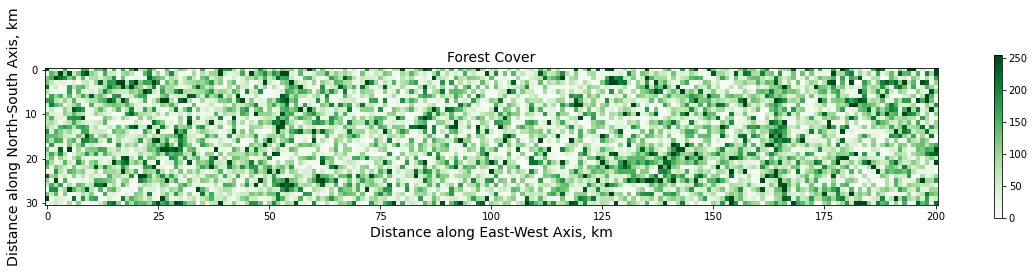

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.89757785 0.96059977 0.87793925 1.        ]
 [0.45176471 0.76708958 0.46120723 1.        ]
 [0.77922338 0.91323337 0.75180315 1.        ]
 [0.62929642 0.85001153 0.6061361  1.        ]
 [0.25259516 0.66812764 0.36286044 1.        ]
 [0.13402537 0.54232987 0.26828143 1.        ]
 [0.         0.42303729 0.17071895 1.        ]
 [0.         0.26666667 0.10588235 1.        ]]


In [64]:
import matplotlib.pyplot as plt
from PIL import Image  #images processing package

def plot_forest():
    #plot forest cover
    plt.figure(figsize=(20, 3))
    plt.imshow(Forest)

    plt.xlabel('Distance along East-West Axis, km', fontsize=14)
    plt.ylabel('Distance along North-South Axis, km', fontsize=14)
    plt.title('Forest Cover', fontsize=14);
    plt.set_cmap("Greens")
    plt.colorbar()
    plt.show()
    
    # access a lookup table for the colormap
    cdict = plt.get_cmap()._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))   
    lookup = np.array(list(map(plt.get_cmap(), step_list)))
    
    print(lookup)

    # create an image for the scenario
    img = Image.new('RGB', (201, 31))
    for i in range(1, nx-1): # march east to west
        for j in range(1, ny-1): # march south to north
            wheresat = (math.floor(Forest[j][i])/255)/.125
            lower = math.floor(wheresat)
            upper = math.ceil(wheresat)
            rval = 255*(lookup[lower][0]*(wheresat-(lower*.125)/.125) + lookup[upper][0]*(1-(wheresat-(lower*.125)/.125)))
            gval = 255*(lookup[lower][1]*(wheresat-(lower*.125)/.125) + lookup[upper][1]*(1-(wheresat-(lower*.125)/.125)))
            bval = 255*(lookup[lower][2]*(wheresat-(lower*.125)/.125) + lookup[upper][2]*(1-(wheresat-(lower*.125)/.125)))
            img.putpixel((i,j), (math.floor(rval), math.floor(gval), math.floor(bval)))
    img.save('forest_out.png')
    
plot_forest()

In [3]:
# Run a hydrology model that identifies water quantity and quality for
# the river that includes fish being considered.

import numpy as np     #numeric processing package
import math as math    #mathematics functions package
import random

# https://max.book118.com/html/2017/0910/133027680.shtm
river_flow = 2.855e10 # cm^3/second  #flow of river at start

#Factors controlling water diffusion
Kh=2.895e-5; #RESEARCH horizontal diffusivity (2.895 x 10^-5 cm^2/s)
Kv=2.895e-5; #RESEARCH vertical diffusivity   (2.895 x 10^-5 cm^2/s)

ntimes=1000; # number of time steps
dt=3600;     # time per time step (one hour)

Winit = [ #initial water for 31 (length) x 201 (width) 2-D array
        [28.129,28.0304,27.9286,27.8248,27.7196,27.6136,27.5073,27.4008,27.2945,27.1884,27.0827,26.9775,26.8727,26.7683,26.6644,26.5609,26.4578,26.355,26.2525,26.1502,26.0481,25.9462,25.8444,25.7427,25.6411,25.5395,25.438,25.3366,25.2351,25.1337,25.0323,24.9309,24.8296,24.7282,24.6268,24.5254,24.4241,24.3227,24.2213,24.1199,24.0186,23.9172,23.8158,23.7144,23.613,23.5116,23.4102,23.3088,23.2073,23.1059,23.0043,22.9028,22.8011,22.6994,22.5976,22.4956,22.3935,22.2912,22.1887,22.086,21.9829,21.8795,21.7757,21.6715,21.5667,21.4615,21.3557,21.2493,21.1435,21.0383,20.9336,20.8294,20.7257,20.6223,20.5192,20.4165,20.3139,20.2116,20.1094,20.0073,19.9053,19.8034,19.7015,19.5997,19.4979,19.3961,19.2943,19.1926,19.0908,18.9891,18.8873,18.7856,18.6838,18.5821,18.4803,18.3786,18.2768,18.1751,18.0733,17.9716,17.8699,17.7681,17.6664,17.5646,17.4629,17.3611,17.2594,17.1577,17.0559,16.9542,16.8524,16.7507,16.6489,16.5471,16.4454,16.3436,16.2417,16.1399,16.038,15.936,15.8339,15.7317,15.6294,15.5268,15.424,15.3208,15.2173,15.1132,15.0086,14.9032,14.797,14.6898,14.5815,14.472,14.3611,14.2517,14.1435,14.0366,13.9307,13.8256,13.7213,13.6175,13.5142,13.4113,13.3086,13.2061,13.1037,13.0014,12.8992,12.7971,12.6949,12.5928,12.4907,12.3886,12.2865,12.1844,12.0823,11.9802,11.8781,11.776,11.6739,11.5718,11.4697,11.3677,11.2656,11.1635,11.0614,10.9593,10.8572,10.7551,10.653,10.5509,10.4488,10.3467,10.2446,10.1425,10.0404,9.9384,9.8363,9.7342,9.6322,9.5303,9.4284,9.3266,7.8704,7.7793,7.6879,8.9218,8.8217,8.7222,8.6235,8.5258,8.4291,8.3335,8.239,8.1457,8.0533,7.9616,7.8704,7.7793,7.6879],
        [28.129,28.0304,27.9286,27.8248,27.7196,27.6136,27.5073,27.4008,27.2945,27.1884,27.0827,26.9775,26.8727,26.7683,26.6644,26.5609,26.4578,26.355,26.2525,26.1502,26.0481,25.9462,25.8444,25.7427,25.6411,25.5395,25.438,25.3366,25.2351,25.1337,25.0323,24.9309,24.8296,24.7282,24.6268,24.5254,24.4241,24.3227,24.2213,24.1199,24.0186,23.9172,23.8158,23.7144,23.613,23.5116,23.4102,23.3088,23.2073,23.1059,23.0043,22.9028,22.8011,22.6994,22.5976,22.4956,22.3935,22.2912,22.1887,22.086,21.9829,21.8795,21.7757,21.6715,21.5667,21.4615,21.3557,21.2493,21.1435,21.0383,20.9336,20.8294,20.7257,20.6223,20.5192,20.4165,20.3139,20.2116,20.1094,20.0073,19.9053,19.8034,19.7015,19.5997,19.4979,19.3961,19.2943,19.1926,19.0908,18.9891,18.8873,18.7856,18.6838,18.5821,18.4803,18.3786,18.2768,18.1751,18.0733,17.9716,17.8699,17.7681,17.6664,17.5646,17.4629,17.3611,17.2594,17.1577,17.0559,16.9542,16.8524,16.7507,16.6489,16.5471,16.4454,16.3436,16.2417,16.1399,16.038,15.936,15.8339,15.7317,15.6294,15.5268,15.424,15.3208,15.2173,15.1132,15.0086,14.9032,14.797,14.6898,14.5815,14.472,14.3611,14.2517,14.1435,14.0366,13.9307,13.8256,13.7213,13.6175,13.5142,13.4113,13.3086,13.2061,13.1037,13.0014,12.8992,12.7971,12.6949,12.5928,12.4907,12.3886,12.2865,12.1844,12.0823,11.9802,11.8781,11.776,11.6739,11.5718,11.4697,11.3677,11.2656,11.1635,11.0614,10.9593,10.8572,10.7551,10.653,10.5509,10.4488,10.3467,10.2446,10.1425,10.0404,9.9384,9.8363,9.7342,9.6322,9.5303,9.4284,9.3266,7.8704,7.7793,7.6879,8.9218,8.8217,8.7222,8.6235,8.5258,8.4291,8.3335,8.239,8.1457,8.0533,7.9616,7.8704,7.7793,7.6879],
        [28.1935,28.08,27.9676,27.856,27.7453,27.6353,27.5261,27.4175,27.3097,27.2027,27.0963,26.9906,26.8856,26.7811,26.6772,26.5738,26.4707,26.3681,26.2657,26.1637,26.0618,25.9601,25.8585,25.757,25.6557,25.5544,25.4531,25.3519,25.2507,25.1495,25.0483,24.9471,24.846,24.7448,24.6437,24.5425,24.4414,24.3403,24.2391,24.138,24.0368,23.9357,23.8345,23.7334,23.6322,23.531,23.4299,23.3287,23.2274,23.1262,23.0249,22.9236,22.8222,22.7207,22.6192,22.5175,22.4157,22.3137,22.2115,22.1091,22.0064,21.9034,21.8001,21.6963,21.592,21.4873,21.382,21.276,21.1708,21.0661,20.962,20.8584,20.7552,20.6523,20.5497,20.4473,20.3452,20.2432,20.1413,20.0396,19.9379,19.8362,19.7347,19.6331,19.5315,19.43,19.3285,19.227,19.1255,19.024,18.9225,18.821,18.7195,18.618,18.5165,18.415,18.3135,18.212,18.1105,18.0091,17.9076,17.8061,17.7046,17.6031,17.5016,17.4001,17.2986,17.1971,17.0956,16.9941,16.8926,16.7911,16.6896,16.5881,16.4866,16.385,16.2835,16.1819,16.0803,15.9786,15.8768,15.775,15.673,15.5708,15.4685,15.3659,15.2629,15.1596,15.0559,14.9516,14.8466,14.741,14.6346,14.5273,14.4191,14.3122,14.2064,14.1015,13.9974,13.8938,13.7908,13.6881,13.5857,13.4834,13.3814,13.2794,13.1775,13.0756,12.9738,12.872,12.7702,12.6685,12.5667,12.4649,12.3631,12.2614,12.1596,12.0578,11.9561,11.8543,11.7525,11.6508,11.549,11.4472,11.3455,11.2437,11.1419,11.0402,10.9384,10.8366,10.7349,10.6331,10.5313,10.4296,10.3278,10.226,10.1243,10.0225,9.9208,9.8191,9.7174,9.6158,9.5142,9.4128,7.9912,7.9094,7.8297,9.01,8.9105,8.8119,8.7143,8.6179,8.5229,8.4296,8.338,8.2483,8.1606,8.0749,7.9912,7.9094,7.8297],
        [28.2581,28.1368,28.0178,27.9009,27.7858,27.6724,27.5605,27.45,27.3407,27.2327,27.1257,27.0196,26.9144,26.81,26.7062,26.603,26.5003,26.398,26.296,26.1944,26.0929,25.9916,25.8905,25.7895,25.6886,25.5877,25.4869,25.3861,25.2854,25.1846,25.0839,24.9832,24.8825,24.7818,24.6811,24.5804,24.4797,24.379,24.2783,24.1776,24.0769,23.9762,23.8755,23.7748,23.6741,23.5734,23.4727,23.3719,23.2712,23.1704,23.0696,22.9687,22.8678,22.7669,22.6658,22.5647,22.4634,22.362,22.2604,22.1587,22.0567,21.9544,21.8518,21.7488,21.6455,21.5418,21.4375,21.3327,21.2286,21.125,21.0219,20.9192,20.8168,20.7147,20.6129,20.5112,20.4097,20.3084,20.2071,20.1059,20.0047,19.9036,19.8025,19.7014,19.6004,19.4993,19.3983,19.2973,19.1963,19.0952,18.9942,18.8932,18.7922,18.6912,18.5901,18.4891,18.3881,18.2871,18.1861,18.085,17.984,17.883,17.782,17.681,17.5799,17.4789,17.3779,17.2769,17.1759,17.0748,16.9738,16.8728,16.7718,16.6707,16.5697,16.4686,16.3676,16.2665,16.1654,16.0642,15.963,15.8617,15.7603,15.6588,15.5571,15.4552,15.3531,15.2508,15.1481,15.045,14.9414,14.8374,14.7327,14.6275,14.5216,14.4168,14.3127,14.2094,14.1066,14.0042,13.9021,13.8003,13.6987,13.5971,13.4957,13.3943,13.293,13.1917,13.0904,12.9892,12.8879,12.7866,12.6854,12.5841,12.4829,12.3816,12.2804,12.1791,12.0779,11.9766,11.8754,11.7741,11.6729,11.5716,11.4704,11.3691,11.2679,11.1666,11.0654,10.9641,10.8629,10.7616,10.6604,10.5591,10.4579,10.3566,10.2554,10.1542,10.0529,9.9517,9.8506,9.7495,9.6485,9.5476,8.1499,8.0727,7.9981,9.1473,9.0487,8.951,8.8544,8.7592,8.6657,8.574,8.4844,8.3971,8.3122,8.2298,8.1499,8.0727,7.9981],
        [28.3226,28.1966,28.0736,27.9534,27.8356,27.7201,27.6066,27.4949,27.3849,27.2764,27.1692,27.0632,26.9582,26.8541,26.7507,26.648,26.5458,26.4441,26.3427,26.2417,26.1408,26.0402,25.9398,25.8394,25.7391,25.6389,25.5388,25.4387,25.3386,25.2385,25.1385,25.0384,24.9384,24.8383,24.7383,24.6383,24.5382,24.4382,24.3382,24.2381,24.1381,24.0381,23.938,23.838,23.7379,23.6379,23.5378,23.4378,23.3377,23.2376,23.1374,23.0373,22.9371,22.8368,22.7365,22.6361,22.5355,22.4349,22.3341,22.2332,22.1321,22.0307,21.9291,21.8272,21.7249,21.6223,21.5193,21.4159,21.313,21.2106,21.1086,21.007,20.9056,20.8044,20.7035,20.6026,20.5019,20.4013,20.3008,20.2003,20.0999,19.9994,19.8991,19.7987,19.6983,19.5979,19.4976,19.3972,19.2969,19.1965,19.0962,18.9959,18.8955,18.7952,18.6948,18.5945,18.4941,18.3938,18.2934,18.1931,18.0928,17.9924,17.8921,17.7917,17.6914,17.591,17.4907,17.3903,17.29,17.1897,17.0893,16.989,16.8886,16.7882,16.6879,16.5875,16.4871,16.3867,16.2863,16.1858,16.0853,15.9847,15.884,15.7833,15.6824,15.5813,15.48,15.3785,15.2767,15.1746,15.072,14.9691,14.8656,14.7616,14.6569,14.5532,14.4502,14.3478,14.2459,14.1443,14.0431,13.942,13.8411,13.7403,13.6395,13.5388,13.4382,13.3376,13.237,13.1364,13.0358,12.9352,12.8347,12.7341,12.6335,12.5329,12.4324,12.3318,12.2312,12.1307,12.0301,11.9295,11.8289,11.7284,11.6278,11.5272,11.4266,11.3261,11.2255,11.1249,11.0243,10.9238,10.8232,10.7226,10.6221,10.5215,10.4209,10.3204,10.2198,10.1193,10.0189,9.9185,9.8182,9.718,8.3418,8.2679,8.197,9.3208,9.223,9.1263,9.0308,8.9368,8.8446,8.7544,8.6665,8.5812,8.4985,8.4187,8.3418,8.2679,8.197],
        [28.3871,28.2584,28.1332,28.0112,27.8921,27.7756,27.6615,27.5496,27.4395,27.3311,27.2243,27.1187,27.0142,26.9107,26.8081,26.7061,26.6047,26.5038,26.4033,26.3031,26.2031,26.1034,26.0038,25.9043,25.8049,25.7056,25.6063,25.5071,25.4078,25.3086,25.2094,25.1103,25.0111,24.9119,24.8127,24.7136,24.6144,24.5152,24.4161,24.3169,24.2177,24.1186,24.0194,23.9202,23.821,23.7219,23.6227,23.5235,23.4243,23.325,23.2258,23.1265,23.0272,22.9278,22.8284,22.7289,22.6293,22.5296,22.4298,22.3298,22.2297,22.1293,22.0288,21.928,21.8269,21.7254,21.6237,21.5215,21.4198,21.3186,21.2177,21.1171,21.0167,20.9165,20.8165,20.7167,20.6169,20.5172,20.4176,20.318,20.2184,20.1189,20.0193,19.9198,19.8203,19.7208,19.6214,19.5219,19.4224,19.3229,19.2234,19.124,19.0245,18.925,18.8255,18.726,18.6266,18.5271,18.4276,18.3281,18.2286,18.1292,18.0297,17.9302,17.8307,17.7312,17.6318,17.5323,17.4328,17.3333,17.2338,17.1343,17.0349,16.9354,16.8359,16.7364,16.6368,16.5373,16.4377,16.3381,16.2385,16.1388,16.039,15.939,15.839,15.7388,15.6384,15.5378,15.4368,15.3356,15.2339,15.1318,15.0291,14.9259,14.8221,14.7192,14.617,14.5155,14.4144,14.3136,14.2132,14.113,14.0129,13.9129,13.8131,13.7132,13.6134,13.5137,13.4139,13.3142,13.2145,13.1147,13.015,12.9153,12.8156,12.7158,12.6161,12.5164,12.4167,12.3169,12.2172,12.1175,12.0178,11.9181,11.8183,11.7186,11.6189,11.5192,11.4194,11.3197,11.22,11.1203,11.0206,10.9208,10.8211,10.7214,10.6217,10.522,10.4223,10.3226,10.223,10.1235,10.0241,9.9248,8.5695,8.4983,8.4304,9.5313,9.4345,9.3388,9.2445,9.1517,9.0608,8.9721,8.8858,8.8023,8.7216,8.6439,8.5695,8.4983,8.4304],
        [28.4516,28.3216,28.1956,28.073,27.9537,27.8372,27.7234,27.6118,27.5023,27.3946,27.2885,27.1837,27.0802,26.9776,26.876,26.775,26.6747,26.5749,26.4754,26.3763,26.2774,26.1787,26.0802,25.9818,25.8834,25.7852,25.687,25.5888,25.4906,25.3925,25.2944,25.1963,25.0982,25.0001,24.902,24.8039,24.7058,24.6077,24.5096,24.4115,24.3134,24.2153,24.1172,24.0191,23.9209,23.8228,23.7247,23.6266,23.5284,23.4303,23.3321,23.2339,23.1356,23.0374,22.939,22.8406,22.7421,22.6435,22.5448,22.446,22.347,22.2478,22.1484,22.0487,21.9488,21.8485,21.748,21.647,21.5465,21.4465,21.3467,21.2472,21.148,21.0489,20.95,20.8513,20.7526,20.6539,20.5554,20.4568,20.3583,20.2599,20.1614,20.063,19.9645,19.8661,19.7677,19.6692,19.5708,19.4724,19.374,19.2756,19.1771,19.0787,18.9803,18.8819,18.7835,18.685,18.5866,18.4882,18.3898,18.2913,18.1929,18.0945,17.9961,17.8977,17.7992,17.7008,17.6024,17.504,17.4056,17.3071,17.2087,17.1103,17.0118,16.9134,16.8149,16.7164,16.6179,16.5194,16.4208,16.3221,16.2233,16.1245,16.0254,15.9263,15.8269,15.7272,15.6273,15.527,15.4262,15.325,15.2233,15.121,15.018,14.9159,14.8147,14.7141,14.6139,14.5142,14.4148,14.3156,14.2165,14.1176,14.0187,13.92,13.8212,13.7225,13.6238,13.5251,13.4264,13.3277,13.229,13.1303,13.0317,12.933,12.8343,12.7356,12.6369,12.5382,12.4396,12.3409,12.2422,12.1435,12.0448,11.9462,11.8475,11.7488,11.6501,11.5514,11.4528,11.3541,11.2554,11.1567,11.058,10.9594,10.8607,10.762,10.6634,10.5648,10.4662,10.3677,10.2693,10.1711,8.8367,8.7677,8.7022,9.782,9.6864,9.5919,9.4987,9.4073,9.3177,9.2305,9.1457,9.0638,8.9848,8.9091,8.8367,8.7677,8.7022],
        [28.5161,28.3862,28.2604,28.1383,28.0196,27.9039,27.7909,27.6803,27.5719,27.4653,27.3603,27.2568,27.1545,27.0532,26.9528,26.8531,26.7541,26.6555,26.5573,26.4595,26.3619,26.2645,26.1672,26.0701,25.973,25.876,25.7791,25.6822,25.5853,25.4885,25.3916,25.2948,25.1979,25.1011,25.0043,24.9075,24.8106,24.7138,24.617,24.5201,24.4233,24.3265,24.2297,24.1328,24.036,23.9391,23.8423,23.7454,23.6486,23.5517,23.4548,23.3578,23.2609,23.1639,23.0668,22.9697,22.8725,22.7752,22.6777,22.5802,22.4825,22.3846,22.2864,22.1881,22.0895,21.9905,21.8913,21.7916,21.6925,21.5937,21.4952,21.397,21.2991,21.2013,21.1036,21.0061,20.9087,20.8113,20.714,20.6168,20.5195,20.4223,20.3251,20.2279,20.1308,20.0336,19.9364,19.8393,19.7421,19.645,19.5478,19.4506,19.3535,19.2563,19.1592,19.062,18.9648,18.8677,18.7705,18.6734,18.5762,18.4791,18.3819,18.2847,18.1876,18.0904,17.9933,17.8961,17.799,17.7018,17.6046,17.5075,17.4103,17.3131,17.216,17.1188,17.0216,16.9243,16.8271,16.7298,16.6324,16.535,16.4375,16.3399,16.2421,16.1441,16.046,15.9475,15.8488,15.7496,15.6501,15.55,15.4494,15.3481,15.2462,15.1452,15.0451,14.9456,14.8467,14.7482,14.65,14.552,14.4542,14.3565,14.2589,14.1614,14.0639,13.9664,13.8689,13.7715,13.674,13.5766,13.4792,13.3817,13.2843,13.1869,13.0894,12.992,12.8946,12.7972,12.6997,12.6023,12.5049,12.4074,12.31,12.2126,12.1151,12.0177,11.9203,11.8228,11.7254,11.628,11.5305,11.4331,11.3357,11.2383,11.1408,11.0434,10.946,10.8487,10.7514,10.6541,10.557,10.46,9.1467,9.0794,9.0158,10.076,9.9817,9.8885,9.7967,9.7066,9.6184,9.5326,9.4493,9.3689,9.2915,9.2174,9.1467,9.0794,9.0158],
        [28.5806,28.452,28.3275,28.2068,28.0895,27.9752,27.8637,27.7545,27.6476,27.5425,27.439,27.337,27.2362,27.1364,27.0375,26.9394,26.8418,26.7447,26.648,26.5517,26.4556,26.3597,26.2639,26.1683,26.0727,25.9772,25.8817,25.7863,25.6909,25.5955,25.5002,25.4048,25.3094,25.2141,25.1187,25.0234,24.928,24.8327,24.7373,24.642,24.5467,24.4513,24.356,24.2606,24.1652,24.0699,23.9745,23.8791,23.7837,23.6883,23.5929,23.4974,23.402,23.3064,23.2109,23.1152,23.0195,22.9237,22.8277,22.7317,22.6354,22.539,22.4424,22.3456,22.2484,22.151,22.0533,21.9551,21.8574,21.7602,21.6632,21.5665,21.47,21.3737,21.2775,21.1815,21.0855,20.9897,20.8938,20.798,20.7023,20.6066,20.5108,20.4151,20.3194,20.2237,20.1281,20.0324,19.9367,19.841,19.7453,19.6496,19.554,19.4583,19.3626,19.2669,19.1712,19.0756,18.9799,18.8842,18.7885,18.6928,18.5971,18.5015,18.4058,18.3101,18.2144,18.1187,18.0231,17.9274,17.8317,17.736,17.6403,17.5446,17.4489,17.3532,17.2575,17.1617,17.0659,16.9701,16.8742,16.7783,16.6822,16.5861,16.4898,16.3933,16.2965,16.1995,16.1022,16.0045,15.9064,15.8077,15.7085,15.6087,15.5081,15.4086,15.3099,15.2118,15.1144,15.0173,14.9205,14.824,14.7277,14.6314,14.5353,14.4392,14.3432,14.2472,14.1512,14.0552,13.9593,13.8633,13.7673,13.6714,13.5754,13.4794,13.3835,13.2875,13.1916,13.0956,12.9996,12.9037,12.8077,12.7117,12.6158,12.5198,12.4239,12.3279,12.2319,12.136,12.04,11.9441,11.8481,11.7521,11.6562,11.5602,11.4643,11.3683,11.2724,11.1765,11.0807,10.9849,10.8892,10.7938,9.502,9.4361,9.3738,10.4156,10.3227,10.231,10.1407,10.052,9.9653,9.8809,9.799,9.72,9.644,9.5713,9.502,9.4361,9.3738],
        [28.6452,28.5189,28.3966,28.2781,28.1629,28.0507,27.9411,27.8339,27.7289,27.6256,27.524,27.4238,27.3248,27.2267,27.1296,27.0332,26.9373,26.842,26.747,26.6523,26.5579,26.4637,26.3696,26.2757,26.1818,26.088,25.9942,25.9005,25.8068,25.7131,25.6194,25.5257,25.432,25.3384,25.2447,25.1511,25.0574,24.9637,24.8701,24.7764,24.6827,24.5891,24.4954,24.4017,24.3081,24.2144,24.1207,24.027,23.9333,23.8396,23.7458,23.6521,23.5583,23.4644,23.3706,23.2766,23.1826,23.0885,22.9942,22.8999,22.8054,22.7107,22.6158,22.5207,22.4253,22.3296,22.2336,22.1373,22.0414,21.9458,21.8506,21.7556,21.6608,21.5662,21.4718,21.3774,21.2832,21.189,21.0949,21.0008,20.9067,20.8127,20.7187,20.6246,20.5306,20.4366,20.3426,20.2487,20.1547,20.0607,19.9667,19.8727,19.7787,19.6847,19.5907,19.4967,19.4028,19.3088,19.2148,19.1208,19.0268,18.9328,18.8388,18.7448,18.6509,18.5569,18.4629,18.3689,18.2749,18.1809,18.0869,17.9929,17.8989,17.8049,17.7109,17.6169,17.5229,17.4288,17.3347,17.2406,17.1464,17.0521,16.9578,16.8633,16.7687,16.6739,16.5789,16.4836,16.388,16.2921,16.1957,16.0988,16.0013,15.9032,15.8044,15.7066,15.6096,15.5133,15.4176,15.3222,15.2272,15.1323,15.0377,14.9432,14.8487,14.7544,14.66,14.5657,14.4714,14.3771,14.2829,14.1886,14.0943,14.0001,13.9058,13.8115,13.7173,13.623,13.5287,13.4345,13.3402,13.2459,13.1517,13.0574,12.9631,12.8689,12.7746,12.6804,12.5861,12.4918,12.3976,12.3033,12.209,12.1148,12.0205,11.9262,11.832,11.7377,11.6435,11.5493,11.4552,11.3611,11.2671,11.1733,9.9039,9.839,9.7777,10.8018,10.7106,10.6205,10.5317,10.4446,10.3594,10.2764,10.196,10.1183,10.0436,9.9721,9.9039,9.839,9.7777],
        [28.7097,28.5868,28.4677,28.3521,28.2397,28.1301,28.023,27.9182,27.8154,27.7144,27.6149,27.5167,27.4197,27.3237,27.2285,27.1341,27.0402,26.9467,26.8537,26.7609,26.6684,26.5761,26.4839,26.3918,26.2998,26.2079,26.116,26.0242,25.9323,25.8405,25.7487,25.6569,25.5651,25.4734,25.3816,25.2898,25.198,25.1062,25.0145,24.9227,24.8309,24.7391,24.6473,24.5556,24.4638,24.372,24.2802,24.1884,24.0966,24.0047,23.9129,23.821,23.7291,23.6372,23.5452,23.4531,23.361,23.2688,23.1765,23.0841,22.9915,22.8988,22.8059,22.7128,22.6194,22.5258,22.4318,22.3375,22.2436,22.1501,22.0568,21.9638,21.871,21.7783,21.6858,21.5934,21.5011,21.4088,21.3166,21.2244,21.1323,21.0401,20.948,20.8559,20.7638,20.6717,20.5796,20.4876,20.3955,20.3034,20.2113,20.1192,20.0271,19.9351,19.843,19.7509,19.6588,19.5667,19.4747,19.3826,19.2905,19.1984,19.1063,19.0142,18.9222,18.8301,18.738,18.6459,18.5538,18.4617,18.3697,18.2776,18.1855,18.0934,18.0013,17.9092,17.817,17.7249,17.6327,17.5405,17.4482,17.3559,17.2635,17.171,17.0783,16.9855,16.8924,16.7991,16.7056,16.6116,16.5173,16.4224,16.3271,16.2311,16.1345,16.0388,15.9439,15.8497,15.7559,15.6625,15.5694,15.4766,15.3838,15.2913,15.1988,15.1063,15.0139,14.9215,14.8291,14.7368,14.6444,14.5521,14.4597,14.3674,14.275,14.1827,14.0904,13.998,13.9057,13.8133,13.721,13.6286,13.5363,13.4439,13.3516,13.2593,13.1669,13.0746,12.9822,12.8899,12.7975,12.7052,12.6129,12.5205,12.4282,12.3358,12.2435,12.1512,12.0589,11.9666,11.8744,11.7822,11.6901,11.5982,10.3521,10.288,10.2273,11.2342,11.1448,11.0564,10.9694,10.8839,10.8003,10.7188,10.6398,10.5634,10.4898,10.4194,10.3521,10.288,10.2273],
        [28.7742,28.6556,28.5405,28.4286,28.3195,28.2131,28.1089,28.0069,27.9067,27.8082,27.7111,27.6153,27.5206,27.4268,27.3338,27.2415,27.1497,27.0584,26.9674,26.8768,26.7863,26.6961,26.606,26.516,26.4261,26.3362,26.2464,26.1566,26.0669,25.9771,25.8874,25.7977,25.7079,25.6182,25.5285,25.4388,25.3491,25.2594,25.1697,25.08,24.9903,24.9005,24.8108,24.7211,24.6314,24.5417,24.452,24.3622,24.2725,24.1827,24.093,24.0032,23.9133,23.8235,23.7336,23.6437,23.5537,23.4636,23.3734,23.2831,23.1927,23.1022,23.0115,22.9206,22.8295,22.7381,22.6465,22.5546,22.463,22.3717,22.2807,22.1899,22.0993,22.0088,21.9184,21.8282,21.738,21.6478,21.5577,21.4677,21.3776,21.2876,21.1976,21.1076,21.0176,20.9276,20.8376,20.7477,20.6577,20.5677,20.4777,20.3878,20.2978,20.2078,20.1178,20.0279,19.9379,19.8479,19.7579,19.6679,19.578,19.488,19.398,19.308,19.2181,19.1281,19.0381,18.9481,18.8582,18.7682,18.6782,18.5882,18.4982,18.4082,18.3183,18.2283,18.1382,18.0482,17.9581,17.8681,17.7779,17.6877,17.5975,17.5071,17.4166,17.326,17.2352,17.1441,17.0528,16.9612,16.8692,16.7768,16.6839,16.5905,16.4965,16.4033,16.3108,16.2189,16.1274,16.0363,15.9454,15.8547,15.7641,15.6737,15.5834,15.4931,15.4028,15.3125,15.2223,15.1321,15.0419,14.9516,14.8614,14.7712,14.681,14.5908,14.5006,14.4104,14.3202,14.23,14.1398,14.0496,13.9593,13.8691,13.7789,13.6887,13.5985,13.5083,13.4181,13.3279,13.2377,13.1475,13.0573,12.9671,12.8769,12.7866,12.6965,12.6063,12.5161,12.4259,12.3358,12.2458,12.1559,12.0661,10.8442,10.7807,10.7203,11.7103,11.6228,11.5364,11.4512,11.3675,11.2855,11.2056,11.1279,11.0528,10.9804,10.9108,10.8442,10.7807,10.7203],
        [28.8387,28.7253,28.6149,28.5073,28.4021,28.2993,28.1985,28.0996,28.0024,27.9066,27.8122,27.719,27.6267,27.5354,27.4448,27.3548,27.2653,27.1762,27.0875,26.9991,26.9109,26.8229,26.7351,26.6473,26.5596,26.472,26.3844,26.2969,26.2093,26.1218,26.0343,25.9468,25.8593,25.7719,25.6844,25.5969,25.5094,25.4219,25.3345,25.247,25.1595,25.072,24.9845,24.8971,24.8096,24.7221,24.6346,24.5471,24.4596,24.3721,24.2846,24.197,24.1095,24.0219,23.9342,23.8466,23.7589,23.6711,23.5832,23.4953,23.4073,23.3191,23.2308,23.1424,23.0538,22.9649,22.8759,22.7866,22.6976,22.6088,22.5203,22.4319,22.3437,22.2555,22.1675,22.0796,21.9917,21.9039,21.8161,21.7283,21.6406,21.5528,21.4651,21.3774,21.2897,21.202,21.1143,21.0266,20.9389,20.8512,20.7635,20.6758,20.5881,20.5004,20.4127,20.3251,20.2374,20.1497,20.062,19.9743,19.8866,19.7989,19.7112,19.6235,19.5358,19.4481,19.3604,19.2727,19.185,19.0973,19.0096,18.9219,18.8342,18.7465,18.6588,18.5711,18.4834,18.3957,18.3079,18.2201,18.1323,18.0444,17.9565,17.8685,17.7804,17.6922,17.6038,17.5152,17.4265,17.3374,17.2481,17.1584,17.0684,16.9779,16.8869,16.7966,16.7068,16.6175,16.5285,16.4399,16.3514,16.2631,16.175,16.0869,15.9989,15.9109,15.823,15.7351,15.6471,15.5593,15.4714,15.3835,15.2956,15.2077,15.1198,15.0319,14.9441,14.8562,14.7683,14.6804,14.5925,14.5046,14.4168,14.3289,14.241,14.1531,14.0652,13.9773,13.8895,13.8016,13.7137,13.6258,13.5379,13.45,13.3622,13.2743,13.1864,13.0986,13.0107,12.9229,12.8351,12.7474,12.6597,12.5722,11.3757,11.3125,11.2521,12.2254,12.1401,12.0557,11.9724,11.8906,11.8103,11.732,11.6558,11.5819,11.5105,11.4417,11.3757,11.3125,11.2521],
        [28.9032,28.7957,28.6906,28.5878,28.487,28.3882,28.2911,28.1956,28.1016,28.009,27.9174,27.827,27.7374,27.6486,27.5605,27.473,27.386,27.2993,27.2131,27.127,27.0412,26.9556,26.8701,26.7847,26.6994,26.6141,26.5289,26.4437,26.3585,26.2734,26.1882,26.1031,26.018,25.9329,25.8477,25.7626,25.6775,25.5924,25.5073,25.4221,25.337,25.2519,25.1668,25.0817,24.9966,24.9114,24.8263,24.7412,24.656,24.5709,24.4858,24.4006,24.3154,24.2302,24.145,24.0598,23.9745,23.8891,23.8038,23.7183,23.6328,23.5472,23.4615,23.3757,23.2898,23.2037,23.1174,23.031,22.9447,22.8587,22.7728,22.687,22.6013,22.5158,22.4303,22.3448,22.2594,22.174,22.0887,22.0034,21.9181,21.8328,21.7475,21.6622,21.5769,21.4916,21.4064,21.3211,21.2358,21.1506,21.0653,20.98,20.8948,20.8095,20.7242,20.639,20.5537,20.4684,20.3832,20.2979,20.2126,20.1273,20.0421,19.9568,19.8715,19.7863,19.701,19.6157,19.5305,19.4452,19.3599,19.2747,19.1894,19.1041,19.0188,18.9336,18.8483,18.763,18.6777,18.5923,18.507,18.4216,18.3361,18.2507,18.1651,18.0795,17.9937,17.9078,17.8218,17.7356,17.6492,17.5625,17.4755,17.3883,17.3006,17.2134,17.1267,17.0402,16.954,16.8681,16.7822,16.6965,16.6109,16.5254,16.4399,16.3544,16.269,16.1836,16.0981,16.0127,15.9273,15.8419,15.7565,15.6711,15.5857,15.5003,15.4149,15.3295,15.2441,15.1587,15.0733,14.9879,14.9025,14.8171,14.7317,14.6463,14.5609,14.4755,14.3901,14.3047,14.2193,14.1339,14.0485,13.9631,13.8777,13.7923,13.7069,13.6215,13.5361,13.4508,13.3654,13.2802,13.195,13.11,11.9395,11.8764,11.8157,12.7726,12.6895,12.6073,12.5261,12.4462,12.3678,12.2911,12.2163,12.1436,12.0732,12.0051,11.9395,11.8764,11.8157],
        [28.9677,28.8666,28.7673,28.6697,28.5737,28.4793,28.3862,28.2944,28.2039,28.1144,28.026,27.9384,27.8517,27.7656,27.6802,27.5952,27.5108,27.4267,27.3429,27.2593,27.176,27.0928,27.0098,26.9268,26.844,26.7611,26.6784,26.5956,26.5129,26.4302,26.3475,26.2649,26.1822,26.0995,26.0169,25.9342,25.8515,25.7689,25.6862,25.6035,25.5209,25.4382,25.3555,25.2729,25.1902,25.1076,25.0249,24.9422,24.8595,24.7769,24.6942,24.6115,24.5288,24.4461,24.3634,24.2806,24.1979,24.1151,24.0323,23.9495,23.8666,23.7836,23.7006,23.6176,23.5344,23.4512,23.3679,23.2845,23.2012,23.118,23.0349,22.9518,22.8689,22.7859,22.7031,22.6202,22.5374,22.4546,22.3718,22.289,22.2063,22.1235,22.0408,21.958,21.8753,21.7925,21.7098,21.6271,21.5443,21.4616,21.3788,21.2961,21.2134,21.1306,21.0479,20.9651,20.8824,20.7996,20.7169,20.6342,20.5514,20.4687,20.3859,20.3032,20.2205,20.1377,20.055,19.9722,19.8895,19.8068,19.724,19.6413,19.5585,19.4758,19.393,19.3103,19.2275,19.1448,19.062,18.9792,18.8965,18.8137,18.7308,18.648,18.5651,18.4821,18.3991,18.3161,18.2329,18.1497,18.0663,17.9828,17.8992,17.8153,17.7313,17.6475,17.5639,17.4805,17.3973,17.3142,17.2311,17.1481,17.0652,16.9823,16.8995,16.8166,16.7338,16.6509,16.5681,16.4853,16.4025,16.3197,16.2369,16.1541,16.0713,15.9884,15.9056,15.8228,15.74,15.6572,15.5744,15.4916,15.4088,15.326,15.2432,15.1603,15.0775,14.9947,14.9119,14.8291,14.7463,14.6635,14.5807,14.4979,14.4151,14.3322,14.2494,14.1666,14.0839,14.0011,13.9184,13.8357,13.7531,13.6706,12.5265,12.4632,12.402,13.3431,13.2624,13.1824,13.1034,13.0255,12.9489,12.8738,12.8005,12.729,12.6594,12.5919,12.5265,12.4632,12.402],
        [29.0323,28.9379,28.8447,28.7527,28.6618,28.5719,28.4831,28.3952,28.3083,28.2223,28.137,28.0525,27.9686,27.8854,27.8027,27.7204,27.6385,27.557,27.4758,27.3948,27.314,27.2333,27.1528,27.0723,26.9919,26.9116,26.8314,26.7511,26.6709,26.5907,26.5105,26.4304,26.3502,26.27,26.1898,26.1097,26.0295,25.9494,25.8692,25.789,25.7089,25.6287,25.5485,25.4684,25.3882,25.3081,25.2279,25.1477,25.0676,24.9874,24.9072,24.8271,24.7469,24.6667,24.5866,24.5064,24.4262,24.346,24.2658,24.1856,24.1054,24.0252,23.945,23.8648,23.7845,23.7042,23.6239,23.5435,23.4632,23.383,23.3027,23.2225,23.1423,23.0621,22.9819,22.9018,22.8216,22.7414,22.6613,22.5811,22.5009,22.4208,22.3406,22.2604,22.1803,22.1001,22.02,21.9398,21.8596,21.7795,21.6993,21.6192,21.539,21.4588,21.3787,21.2985,21.2184,21.1382,21.058,20.9779,20.8977,20.8175,20.7374,20.6572,20.5771,20.4969,20.4167,20.3366,20.2564,20.1763,20.0961,20.0159,19.9358,19.8556,19.7754,19.6953,19.6151,19.535,19.4548,19.3746,19.2945,19.2143,19.1341,19.054,18.9738,18.8936,18.8134,18.7332,18.653,18.5728,18.4926,18.4123,18.3321,18.2518,18.1714,18.0912,18.0109,17.9307,17.8505,17.7703,17.6901,17.61,17.5298,17.4496,17.3695,17.2893,17.2091,17.129,17.0488,16.9687,16.8885,16.8083,16.7282,16.648,16.5679,16.4877,16.4075,16.3274,16.2472,16.1671,16.0869,16.0067,15.9266,15.8464,15.7662,15.6861,15.6059,15.5258,15.4456,15.3654,15.2853,15.2051,15.125,15.0448,14.9646,14.8845,14.8043,14.7242,14.644,14.5639,14.4838,14.4038,14.3238,14.2439,13.1264,13.0624,13,13.9266,13.8483,13.7707,13.6939,13.6181,13.5434,13.4701,13.3982,13.3278,13.2591,13.1919,13.1264,13.0624,13],
        [29.0968,29.0094,28.9226,28.8364,28.7507,28.6656,28.5811,28.4973,28.4142,28.3316,28.2496,28.1682,28.0873,28.0069,27.927,27.8474,27.7682,27.6892,27.6106,27.5321,27.4538,27.3757,27.2976,27.2197,27.1418,27.064,26.9863,26.9085,26.8308,26.7531,26.6754,26.5977,26.5201,26.4424,26.3647,26.2871,26.2094,26.1317,26.0541,25.9764,25.8988,25.8211,25.7434,25.6658,25.5881,25.5105,25.4328,25.3551,25.2775,25.1998,25.1222,25.0445,24.9669,24.8893,24.8116,24.734,24.6564,24.5788,24.5012,24.4237,24.3461,24.2686,24.1912,24.1137,24.0363,23.959,23.8817,23.8044,23.7271,23.6498,23.5724,23.495,23.4175,23.3401,23.2626,23.1851,23.1076,23.0301,22.9525,22.875,22.7974,22.7198,22.6423,22.5647,22.4871,22.4095,22.332,22.2544,22.1768,22.0992,22.0216,21.9441,21.8665,21.7889,21.7113,21.6337,21.5562,21.4786,21.401,21.3234,21.2458,21.1682,21.0907,21.0131,20.9355,20.8579,20.7803,20.7028,20.6252,20.5476,20.47,20.3924,20.3148,20.2373,20.1597,20.0821,20.0045,19.927,19.8494,19.7718,19.6943,19.6168,19.5392,19.4617,19.3843,19.3068,19.2294,19.1521,19.0748,18.9976,18.9205,18.8435,18.7666,18.6899,18.6132,18.5365,18.4596,18.3825,18.3054,18.2282,18.1509,18.0735,17.9961,17.9187,17.8412,17.7638,17.6863,17.6088,17.5313,17.4538,17.3763,17.2988,17.2213,17.1437,17.0662,16.9887,16.9112,16.8337,16.7562,16.6787,16.6012,16.5237,16.4461,16.3686,16.2911,16.2136,16.1361,16.0586,15.9811,15.9036,15.826,15.7485,15.671,15.5935,15.516,15.4385,15.361,15.2835,15.206,15.1285,15.0511,14.9737,14.8963,14.8191,13.7358,13.6681,13.598,14.5125,14.437,14.3621,14.2882,14.2152,14.1435,14.073,14.0038,13.9358,13.8688,13.8024,13.7358,13.6681,13.598],
        [29.1613,29.081,29.0007,28.9203,28.8399,28.7597,28.6798,28.6001,28.5207,28.4416,28.363,28.2847,28.2068,28.1293,28.0521,27.9752,27.8985,27.8222,27.746,27.6701,27.5943,27.5186,27.443,27.3676,27.2922,27.2168,27.1415,27.0662,26.9909,26.9157,26.8405,26.7652,26.69,26.6148,26.5396,26.4644,26.3892,26.3139,26.2387,26.1635,26.0883,26.0131,25.9379,25.8627,25.7875,25.7123,25.6371,25.5619,25.4867,25.4115,25.3363,25.2611,25.186,25.1108,25.0357,24.9606,24.8855,24.8104,24.7354,24.6604,24.5855,24.5106,24.4358,24.3611,24.2865,24.212,24.1375,24.0633,23.9889,23.9144,23.8399,23.7652,23.6905,23.6157,23.5409,23.466,23.3911,23.3161,23.2412,23.1662,23.0912,23.0162,22.9411,22.8661,22.791,22.716,22.6409,22.5659,22.4908,22.4158,22.3407,22.2657,22.1906,22.1156,22.0405,21.9655,21.8904,21.8154,21.7403,21.6652,21.5902,21.5151,21.4401,21.365,21.29,21.2149,21.1399,21.0648,20.9898,20.9147,20.8396,20.7646,20.6895,20.6145,20.5394,20.4644,20.3894,20.3143,20.2393,20.1643,20.0893,20.0143,19.9394,19.8645,19.7897,19.7149,19.6402,19.5656,19.4912,19.4169,19.3428,19.2689,19.1952,19.1219,19.0488,18.9754,18.9018,18.8279,18.7537,18.6794,18.605,18.5304,18.4557,18.381,18.3062,18.2313,18.1565,18.0816,18.0067,17.9318,17.8569,17.7819,17.707,17.6321,17.5572,17.4823,17.4074,17.3324,17.2575,17.1826,17.1077,17.0327,16.9578,16.8829,16.808,16.7331,16.6581,16.5832,16.5083,16.4334,16.3585,16.2835,16.2086,16.1337,16.0588,15.9839,15.909,15.8341,15.7592,15.6843,15.6095,15.5347,15.46,15.3856,14.5086,14.4972,14.4972,15.0918,15.0205,14.9507,14.883,14.818,14.7563,14.6989,14.6466,14.6004,14.5613,14.5303,14.5086,14.4972,14.4972],
        [29.2258,29.1526,29.0786,29.0041,28.9291,28.8538,28.7784,28.7028,28.6272,28.5518,28.4764,28.4012,28.3263,28.2515,28.177,28.1028,28.0287,27.9548,27.8811,27.8076,27.7342,27.6609,27.5877,27.5146,27.4416,27.3686,27.2956,27.2227,27.1498,27.0769,27.0041,26.9312,26.8583,26.7855,26.7126,26.6398,26.5669,26.4941,26.4212,26.3484,26.2755,26.2027,26.1299,26.057,25.9842,25.9113,25.8385,25.7657,25.6928,25.62,25.5472,25.4744,25.4016,25.3288,25.2561,25.1834,25.1107,25.038,24.9654,24.8929,24.8205,24.7481,24.6759,24.6037,24.5317,24.4599,24.3882,24.3168,24.2452,24.1734,24.1015,24.0295,23.9574,23.8852,23.8129,23.7405,23.6681,23.5957,23.5232,23.4506,23.3781,23.3055,23.2329,23.1603,23.0877,23.0151,22.9424,22.8698,22.7972,22.7246,22.6519,22.5793,22.5067,22.4341,22.3614,22.2888,22.2162,22.1435,22.0709,21.9983,21.9257,21.853,21.7804,21.7078,21.6351,21.5625,21.4899,21.4173,21.3446,21.272,21.1994,21.1267,21.0541,20.9815,20.9089,20.8363,20.7636,20.691,20.6185,20.5459,20.4733,20.4008,20.3283,20.2559,20.1836,20.1114,20.0392,19.9673,19.8955,19.8239,19.7526,19.6816,19.611,19.5408,19.471,19.4008,19.3302,19.2593,19.188,19.1165,19.0447,18.9728,18.9007,18.8285,18.7563,18.684,18.6116,18.5392,18.4668,18.3944,18.322,18.2496,18.1771,18.1047,18.0323,17.9598,17.8874,17.815,17.7425,17.6701,17.5976,17.5252,17.4528,17.3803,17.3079,17.2354,17.163,17.0906,17.0181,16.9457,16.8732,16.8008,16.7284,16.6559,16.5835,16.511,16.4386,16.3662,16.2938,16.2214,16.149,16.0767,16.0045,15.9324,15.0907,15.0806,15.0806,15.6481,15.5791,15.5116,15.4462,15.3834,15.3241,15.269,15.2191,15.1754,15.1388,15.1103,15.0907,15.0806,15.0806],
        [29.2903,29.224,29.1564,29.0877,29.018,28.9476,28.8766,28.8051,28.7334,28.6614,28.5893,28.5172,28.4451,28.3731,28.3012,28.2294,28.1578,28.0863,28.015,27.9437,27.8726,27.8016,27.7307,27.6598,27.589,27.5183,27.4475,27.3769,27.3062,27.2355,27.1649,27.0942,27.0236,26.953,26.8824,26.8118,26.7411,26.6705,26.5999,26.5293,26.4587,26.3881,26.3175,26.2468,26.1762,26.1056,26.035,25.9644,25.8938,25.8232,25.7527,25.6821,25.6115,25.541,25.4705,25.4,25.3296,25.2592,25.1889,25.1187,25.0486,24.9786,24.9087,24.8389,24.7694,24.7,24.6309,24.562,24.493,24.4237,24.3543,24.2848,24.2151,24.1453,24.0754,24.0054,23.9353,23.8652,23.795,23.7248,23.6545,23.5842,23.5139,23.4436,23.3733,23.303,23.2326,23.1623,23.092,23.0216,22.9513,22.8809,22.8106,22.7402,22.6699,22.5996,22.5292,22.4589,22.3885,22.3182,22.2478,22.1775,22.1071,22.0368,21.9664,21.8961,21.8257,21.7554,21.6851,21.6147,21.5444,21.474,21.4037,21.3333,21.263,21.1927,21.1223,21.052,20.9817,20.9114,20.8412,20.771,20.7008,20.6307,20.5607,20.4908,20.421,20.3514,20.2821,20.213,20.1442,20.0759,20.008,19.9406,19.8738,19.8065,19.7387,19.6705,19.6018,19.5329,19.4637,19.3942,19.3246,19.2548,19.185,19.115,19.045,18.975,18.9049,18.8349,18.7648,18.6947,18.6246,18.5544,18.4843,18.4142,18.3441,18.274,18.2039,18.1338,18.0637,17.9935,17.9234,17.8533,17.7832,17.7131,17.643,17.5729,17.5027,17.4326,17.3625,17.2924,17.2223,17.1522,17.0821,17.0119,16.9418,16.8717,16.8016,16.7316,16.6615,16.5915,16.5216,16.4517,15.6245,15.6141,15.6141,16.1757,16.1085,16.0426,15.9785,15.9169,15.8584,15.8038,15.7541,15.7104,15.6735,15.6445,15.6245,15.6141,15.6141],
        [29.3548,29.2952,29.2337,29.1707,29.1063,29.0406,28.9741,28.9066,28.8386,28.7701,28.7012,28.632,28.5627,28.4933,28.424,28.3546,28.2853,28.216,28.1469,28.0778,28.0088,27.9399,27.8711,27.8023,27.7336,27.6649,27.5963,27.5277,27.459,27.3905,27.3219,27.2533,27.1848,27.1162,27.0477,26.9791,26.9106,26.842,26.7735,26.7049,26.6364,26.5678,26.4993,26.4307,26.3622,26.2937,26.2251,26.1566,26.0881,26.0196,25.951,25.8825,25.8141,25.7456,25.6772,25.6088,25.5405,25.4722,25.404,25.3358,25.2678,25.1999,25.1322,25.0646,24.9973,24.9301,24.8633,24.7967,24.73,24.663,24.5959,24.5286,24.4611,24.3935,24.3258,24.258,24.19,24.1221,24.054,23.9859,23.9178,23.8497,23.7815,23.7133,23.6451,23.5769,23.5086,23.4404,23.3722,23.3039,23.2357,23.1674,23.0992,23.031,22.9627,22.8945,22.8262,22.758,22.6898,22.6215,22.5533,22.485,22.4168,22.3486,22.2803,22.2121,22.1438,22.0756,22.0074,21.9391,21.8709,21.8026,21.7344,21.6662,21.5979,21.5297,21.4615,21.3933,21.3251,21.2569,21.1887,21.1206,21.0526,20.9846,20.9167,20.8489,20.7813,20.7139,20.6467,20.5798,20.5133,20.4473,20.3817,20.3168,20.2526,20.1878,20.1225,20.0567,19.9904,19.9238,19.8569,19.7897,19.7223,19.6548,19.5871,19.5194,19.4515,19.3837,19.3157,19.2478,19.1799,19.1119,19.0439,18.9759,18.908,18.84,18.772,18.704,18.6361,18.5681,18.5001,18.4321,18.3641,18.2962,18.2282,18.1602,18.0922,18.0242,17.9563,17.8883,17.8203,17.7523,17.6844,17.6164,17.5484,17.4804,17.4124,17.3445,17.2765,17.2085,17.1406,17.0727,17.0049,16.9371,16.1206,16.1097,16.1097,16.6687,16.6031,16.5386,16.4757,16.4149,16.3569,16.3026,16.2528,16.2086,16.1711,16.1414,16.1206,16.1097,16.1097],
        [29.4194,29.3661,29.3105,29.253,29.1937,29.1328,29.0705,29.0071,28.9427,28.8775,28.8117,28.7454,28.6788,28.6119,28.5449,28.4778,28.4107,28.3435,28.2764,28.2093,28.1423,28.0754,28.0084,27.9416,27.8747,27.808,27.7412,27.6745,27.6077,27.541,27.4743,27.4077,27.341,27.2743,27.2076,27.141,27.0743,27.0077,26.941,26.8743,26.8077,26.741,26.6744,26.6077,26.541,26.4744,26.4077,26.3411,26.2744,26.2078,26.1412,26.0746,26.008,25.9414,25.8748,25.8083,25.7419,25.6755,25.6092,25.5429,25.4768,25.4108,25.345,25.2794,25.214,25.1488,25.0839,25.0194,24.9547,24.8897,24.8246,24.7593,24.6938,24.6282,24.5624,24.4965,24.4306,24.3645,24.2984,24.2323,24.1661,24.0998,24.0336,23.9673,23.901,23.8347,23.7684,23.7021,23.6357,23.5694,23.5031,23.4367,23.3704,23.3041,23.2377,23.1714,23.1051,23.0387,22.9724,22.9061,22.8397,22.7734,22.7071,22.6407,22.5744,22.508,22.4417,22.3754,22.309,22.2427,22.1764,22.11,22.0437,21.9774,21.9111,21.8447,21.7784,21.7121,21.6458,21.5795,21.5133,21.4471,21.3809,21.3148,21.2488,21.1829,21.1172,21.0517,20.9864,20.9215,20.8569,20.7928,20.7293,20.6664,20.6043,20.5417,20.4785,20.4148,20.3506,20.2861,20.2212,20.1561,20.0907,20.0252,19.9595,19.8937,19.8278,19.7618,19.6959,19.6299,19.5638,19.4978,19.4317,19.3657,19.2996,19.2336,19.1675,19.1015,19.0354,18.9694,18.9033,18.8372,18.7712,18.7051,18.6391,18.573,18.507,18.4409,18.3748,18.3088,18.2427,18.1767,18.1106,18.0446,17.9785,17.9124,17.8464,17.7803,17.7143,17.6482,17.5822,17.5162,17.4502,17.3844,16.5761,16.5647,16.5647,17.1228,17.0586,16.9954,16.9335,16.8735,16.8159,16.7617,16.7117,16.6669,16.6285,16.5979,16.5761,16.5647,16.5647],
        [29.4839,29.4366,29.3868,29.3345,29.2801,29.2238,29.1657,29.1062,29.0453,28.9834,28.9206,28.8571,28.7931,28.7286,28.6638,28.5988,28.5337,28.4685,28.4033,28.338,28.2728,28.2075,28.1423,28.0772,28.0121,27.947,27.8819,27.8168,27.7518,27.6868,27.6218,27.5568,27.4918,27.4268,27.3618,27.2969,27.2319,27.1669,27.1019,27.0369,26.972,26.907,26.842,26.777,26.7121,26.6471,26.5821,26.5172,26.4522,26.3872,26.3223,26.2574,26.1925,26.1276,26.0627,25.9979,25.9331,25.8684,25.8037,25.7391,25.6747,25.6104,25.5462,25.4823,25.4186,25.3551,25.292,25.2292,25.1662,25.103,25.0396,24.976,24.9123,24.8484,24.7844,24.7202,24.656,24.5917,24.5273,24.4628,24.3983,24.3338,24.2693,24.2047,24.1401,24.0755,24.0108,23.9462,23.8816,23.8169,23.7523,23.6877,23.623,23.5584,23.4937,23.4291,23.3645,23.2998,23.2352,23.1705,23.1059,23.0413,22.9766,22.912,22.8473,22.7827,22.7181,22.6534,22.5888,22.5241,22.4595,22.3948,22.3302,22.2656,22.2009,22.1363,22.0717,22.0071,21.9424,21.8778,21.8133,21.7487,21.6843,21.6198,21.5555,21.4913,21.4272,21.3633,21.2997,21.2364,21.1734,21.111,21.0491,20.9879,20.9276,20.8666,20.8052,20.7433,20.681,20.6182,20.5551,20.4917,20.4281,20.3643,20.3004,20.2363,20.1721,20.1079,20.0436,19.9793,19.915,19.8507,19.7863,19.722,19.6576,19.5933,19.5289,19.4645,19.4002,19.3358,19.2715,19.2071,19.1427,19.0784,19.014,18.9497,18.8853,18.8209,18.7566,18.6922,18.6279,18.5635,18.4991,18.4348,18.3704,18.3061,18.2417,18.1773,18.113,18.0486,17.9843,17.92,17.8557,17.7914,16.9891,16.9769,16.9769,17.536,17.4731,17.4109,17.3499,17.2905,17.2333,17.179,17.1286,17.0831,17.0437,17.0119,16.9891,16.9769,16.9769],
        [29.5484,29.5068,29.4623,29.4151,29.3654,29.3135,29.2595,29.2037,29.1463,29.0876,29.0277,28.9669,28.9053,28.8431,28.7804,28.7174,28.6541,28.5907,28.5272,28.4635,28.3999,28.3362,28.2726,28.2089,28.1453,28.0817,28.0181,27.9545,27.891,27.8274,27.7639,27.7004,27.6369,27.5734,27.5099,27.4464,27.3829,27.3194,27.2559,27.1924,27.1289,27.0654,27.0019,26.9384,26.8749,26.8114,26.7479,26.6844,26.6209,26.5575,26.494,26.4305,26.3671,26.3037,26.2403,26.1769,26.1136,26.0503,25.9871,25.924,25.861,25.7982,25.7355,25.673,25.6107,25.5487,25.487,25.4257,25.3642,25.3025,25.2406,25.1786,25.1163,25.054,24.9915,24.9288,24.8661,24.8033,24.7404,24.6774,24.6144,24.5514,24.4883,24.4252,24.3621,24.299,24.2358,24.1727,24.1095,24.0464,23.9832,23.92,23.8569,23.7937,23.7305,23.6674,23.6042,23.541,23.4779,23.4147,23.3515,23.2884,23.2252,23.1621,23.0989,23.0357,22.9726,22.9094,22.8462,22.7831,22.7199,22.6567,22.5936,22.5304,22.4672,22.4041,22.3409,22.2778,22.2146,22.1515,22.0884,22.0253,21.9623,21.8993,21.8364,21.7736,21.7109,21.6485,21.5862,21.5242,21.4627,21.4015,21.341,21.2811,21.2221,21.1626,21.1026,21.0422,20.9813,20.9201,20.8585,20.7966,20.7345,20.6722,20.6098,20.5472,20.4845,20.4218,20.359,20.2962,20.2333,20.1705,20.1076,20.0447,19.9818,19.9189,19.856,19.7932,19.7303,19.6674,19.6045,19.5416,19.4787,19.4158,19.3529,19.29,19.2271,19.1642,19.1014,19.0385,18.9756,18.9127,18.8498,18.7869,18.724,18.6611,18.5982,18.5353,18.4724,18.4096,18.3467,18.2838,18.221,18.1582,17.3594,17.3463,17.3463,17.908,17.8462,17.785,17.7248,17.6659,17.6088,17.5544,17.5035,17.4571,17.4166,17.3834,17.3594,17.3463,17.3463],
        [29.6129,29.5765,29.537,29.4946,29.4494,29.4017,29.3516,29.2994,29.2453,29.1897,29.1326,29.0743,29.015,28.955,28.8943,28.8331,28.7715,28.7097,28.6476,28.5855,28.5232,28.4609,28.3986,28.3363,28.2739,28.2116,28.1493,28.087,28.0248,27.9625,27.9002,27.838,27.7757,27.7135,27.6513,27.589,27.5268,27.4646,27.4024,27.3401,27.2779,27.2157,27.1535,27.0912,27.029,26.9668,26.9046,26.8424,26.7801,26.7179,26.6557,26.5935,26.5314,26.4692,26.4071,26.345,26.2829,26.2209,26.159,26.0971,26.0354,25.9738,25.9123,25.8511,25.7901,25.7294,25.669,25.609,25.5488,25.4885,25.4279,25.3672,25.3062,25.2452,25.184,25.1226,25.0612,24.9997,24.9381,24.8764,24.8147,24.7529,24.6911,24.6293,24.5674,24.5056,24.4437,24.3818,24.3199,24.258,24.1961,24.1342,24.0723,24.0104,23.9485,23.8866,23.8247,23.7628,23.7009,23.639,23.5771,23.5152,23.4533,23.3914,23.3295,23.2676,23.2057,23.1438,23.0819,23.02,22.9581,22.8962,22.8343,22.7724,22.7105,22.6486,22.5867,22.5248,22.4629,22.4011,22.3392,22.2774,22.2156,22.1538,22.0922,22.0306,21.9691,21.9078,21.8467,21.7858,21.7253,21.6653,21.6058,21.5469,21.4889,21.4305,21.3716,21.3124,21.2527,21.1927,21.1324,21.0718,21.011,20.95,20.8888,20.8275,20.7661,20.7046,20.6431,20.5815,20.5199,20.4583,20.3967,20.3351,20.2734,20.2118,20.1501,20.0885,20.0269,19.9652,19.9036,19.8419,19.7803,19.7187,19.657,19.5954,19.5337,19.4721,19.4104,19.3488,19.2872,19.2255,19.1639,19.1022,19.0406,18.979,18.9173,18.8557,18.794,18.7324,18.6708,18.6091,18.5475,18.4859,17.6885,17.6744,17.6744,18.2404,18.1795,18.1191,18.0595,18.001,17.9441,17.8894,17.8378,17.7904,17.7486,17.714,17.6885,17.6744,17.6744],
        [29.6774,29.6457,29.6107,29.5726,29.5316,29.4877,29.4413,29.3925,29.3415,29.2887,29.2342,29.1783,29.1212,29.0631,29.0042,28.9447,28.8846,28.8242,28.7635,28.7026,28.6416,28.5805,28.5193,28.4581,28.3968,28.3356,28.2744,28.2132,28.152,28.0908,28.0296,27.9684,27.9072,27.8461,27.7849,27.7237,27.6626,27.6014,27.5402,27.4791,27.4179,27.3568,27.2956,27.2345,27.1733,27.1121,27.051,26.9898,26.9287,26.8676,26.8064,26.7453,26.6842,26.6231,26.562,26.501,26.44,26.379,26.3182,26.2574,26.1967,26.1362,26.0759,26.0158,25.9559,25.8964,25.8373,25.7786,25.7197,25.6606,25.6013,25.5418,25.4821,25.4222,25.3622,25.302,25.2417,25.1813,25.1208,25.0603,24.9996,24.9389,24.8782,24.8175,24.7567,24.6959,24.6351,24.5743,24.5134,24.4526,24.3918,24.3309,24.2701,24.2093,24.1484,24.0876,24.0267,23.9659,23.905,23.8442,23.7834,23.7225,23.6617,23.6008,23.54,23.4791,23.4183,23.3575,23.2966,23.2358,23.1749,23.1141,23.0532,22.9924,22.9316,22.8707,22.8099,22.7491,22.6882,22.6274,22.5666,22.5058,22.4451,22.3843,22.3237,22.2631,22.2026,22.1422,22.0821,22.0222,21.9626,21.9034,21.8448,21.7868,21.7296,21.672,21.6141,21.5558,21.4971,21.4381,21.3789,21.3193,21.2595,21.1996,21.1395,21.0792,21.0189,20.9584,20.898,20.8374,20.7769,20.7163,20.6558,20.5952,20.5346,20.474,20.4134,20.3528,20.2922,20.2316,20.171,20.1104,20.0498,19.9892,19.9286,19.868,19.8074,19.7468,19.6862,19.6256,19.565,19.5044,19.4438,19.3832,19.3226,19.262,19.2014,19.1408,19.0802,19.0196,18.959,18.8984,18.8378,18.7772,17.9792,17.9639,17.9639,18.5355,18.4755,18.4158,18.3567,18.2985,18.2415,18.1865,18.1343,18.0858,18.0426,18.0063,17.9792,17.9639,17.9639],
        [29.7419,29.7141,29.683,29.6486,29.6111,29.5705,29.5272,29.4813,29.4331,29.3827,29.3305,29.2767,29.2215,29.1651,29.1078,29.0497,28.991,28.9318,28.8722,28.8124,28.7523,28.6922,28.6319,28.5716,28.5113,28.451,28.3906,28.3303,28.2699,28.2096,28.1493,28.089,28.0286,27.9683,27.908,27.8477,27.7874,27.7271,27.6669,27.6066,27.5463,27.486,27.4257,27.3654,27.3051,27.2448,27.1845,27.1242,27.064,27.0037,26.9434,26.8831,26.8229,26.7627,26.7025,26.6423,26.5822,26.5221,26.4621,26.4023,26.3425,26.283,26.2236,26.1646,26.1059,26.0476,25.9898,25.9327,25.8752,25.8175,25.7595,25.7013,25.6428,25.5841,25.5252,25.4662,25.407,25.3476,25.2881,25.2285,25.1688,25.1091,25.0493,24.9894,24.9296,24.8697,24.8097,24.7498,24.6898,24.6299,24.5699,24.5099,24.45,24.39,24.33,24.27,24.2101,24.1501,24.0901,24.0301,23.9701,23.9102,23.8502,23.7902,23.7302,23.6702,23.6103,23.5503,23.4903,23.4303,23.3704,23.3104,23.2504,23.1904,23.1304,23.0705,23.0105,22.9505,22.8906,22.8306,22.7706,22.7107,22.6508,22.5909,22.5311,22.4713,22.4117,22.3522,22.2928,22.2337,22.1749,22.1166,22.0588,22.0017,21.9454,21.8888,21.8318,21.7743,21.7166,21.6585,21.6001,21.5415,21.4826,21.4235,21.3643,21.3049,21.2455,21.1859,21.1263,21.0666,21.0069,20.9472,20.8875,20.8278,20.768,20.7083,20.6485,20.5888,20.529,20.4693,20.4096,20.3498,20.2901,20.2303,20.1706,20.1108,20.0511,19.9913,19.9316,19.8718,19.8121,19.7523,19.6926,19.6328,19.5731,19.5133,19.4536,19.3938,19.3341,19.2743,19.2146,19.1548,19.0951,19.0353,18.2348,18.2183,18.2183,18.7968,18.7374,18.6783,18.6196,18.5616,18.5047,18.4493,18.3963,18.3467,18.3019,18.2638,18.2348,18.2183,18.2183],
        [29.8065,29.7814,29.7529,29.721,29.6858,29.6476,29.6065,29.5627,29.5164,29.4679,29.4174,29.3652,29.3114,29.2564,29.2003,29.1433,29.0856,29.0274,28.9687,28.9097,28.8505,28.7911,28.7315,28.6719,28.6123,28.5526,28.4929,28.4332,28.3736,28.3139,28.2542,28.1946,28.1349,28.0753,28.0156,27.956,27.8964,27.8367,27.7771,27.7175,27.6578,27.5982,27.5386,27.4789,27.4193,27.3597,27.3001,27.2404,27.1808,27.1212,27.0616,27.002,26.9424,26.8828,26.8233,26.7638,26.7044,26.645,26.5857,26.5266,26.4676,26.4089,26.3505,26.2924,26.2348,26.1778,26.1216,26.0663,26.0106,25.9546,25.8982,25.8415,25.7844,25.727,25.6694,25.6115,25.5533,25.495,25.4364,25.3777,25.3189,25.26,25.201,25.1419,25.0828,25.0236,24.9643,24.9051,24.8458,24.7866,24.7273,24.668,24.6087,24.5494,24.4901,24.4308,24.3715,24.3122,24.2529,24.1936,24.1343,24.075,24.0157,23.9564,23.8971,23.8378,23.7785,23.7192,23.6598,23.6005,23.5412,23.4819,23.4226,23.3633,23.304,23.2447,23.1854,23.1261,23.0668,23.0075,22.9483,22.889,22.8298,22.7706,22.7114,22.6523,22.5934,22.5345,22.4759,22.4176,22.3597,22.3024,22.2457,22.1899,22.1354,22.0803,22.0247,21.9686,21.9121,21.8552,21.7979,21.7402,21.6823,21.6241,21.5657,21.5071,21.4484,21.3896,21.3307,21.2717,21.2127,21.1537,21.0947,21.0356,20.9766,20.9175,20.8584,20.7994,20.7403,20.6812,20.6222,20.5631,20.504,20.4449,20.3859,20.3268,20.2677,20.2086,20.1496,20.0905,20.0314,19.9724,19.9133,19.8542,19.7951,19.7361,19.677,19.6179,19.5589,19.4998,19.4407,19.3816,19.3226,19.2635,18.4591,18.4411,18.4411,19.0275,18.9686,18.91,18.8517,18.7938,18.7368,18.6811,18.6273,18.5765,18.5301,18.4901,18.4591,18.4411,18.4411],
        [29.871,29.8462,29.8178,29.7862,29.7514,29.7137,29.6733,29.6302,29.5848,29.5372,29.4876,29.4363,29.3835,29.3293,29.274,29.2177,29.1607,29.1031,29.045,28.9866,28.9279,28.869,28.8099,28.7508,28.6916,28.6324,28.5732,28.514,28.4547,28.3955,28.3363,28.2771,28.2179,28.1587,28.0995,28.0403,27.9811,27.9219,27.8627,27.8036,27.7444,27.6852,27.626,27.5668,27.5076,27.4485,27.3893,27.3301,27.2709,27.2118,27.1526,27.0935,27.0343,26.9752,26.9161,26.8571,26.7981,26.7393,26.6805,26.6219,26.5635,26.5054,26.4477,26.3905,26.3339,26.2782,26.2236,26.1704,26.1167,26.0625,26.0079,25.9528,25.8972,25.8413,25.7849,25.7282,25.6711,25.6137,25.5561,25.4982,25.4402,25.3819,25.3236,25.2651,25.2065,25.1479,25.0892,25.0305,24.9717,24.9129,24.8541,24.7953,24.7365,24.6777,24.6189,24.56,24.5012,24.4424,24.3836,24.3247,24.2659,24.2071,24.1482,24.0894,24.0306,23.9718,23.9129,23.8541,23.7953,23.7364,23.6776,23.6188,23.56,23.5011,23.4423,23.3835,23.3247,23.2658,23.207,23.1482,23.0894,23.0306,22.9719,22.9131,22.8545,22.7959,22.7375,22.6793,22.6214,22.5639,22.507,22.4509,22.396,22.3426,22.2912,22.2392,22.1864,22.133,22.0789,22.0242,21.9688,21.9129,21.8564,21.7996,21.7423,21.6847,21.6269,21.5689,21.5107,21.4524,21.394,21.3355,21.2771,21.2185,21.16,21.1015,21.0429,20.9844,20.9258,20.8673,20.8087,20.7502,20.6916,20.6331,20.5745,20.5159,20.4574,20.3988,20.3403,20.2817,20.2232,20.1646,20.1061,20.0475,19.9889,19.9304,19.8718,19.8133,19.7547,19.6962,19.6376,19.5791,19.5205,19.462,18.6525,18.6328,18.6328,19.2279,19.1695,19.1112,19.0531,18.9954,18.9383,18.8822,18.8277,18.7757,18.7277,18.6856,18.6525,18.6328,18.6328],
        [29.9355,29.903,29.8692,29.8339,29.7967,29.7574,29.716,29.6725,29.6269,29.5793,29.53,29.4789,29.4264,29.3726,29.3176,29.2617,29.2051,29.1478,29.09,29.0319,28.9734,28.9148,28.856,28.7971,28.7382,28.6792,28.6202,28.5612,28.5022,28.4432,28.3842,28.3252,28.2662,28.2072,28.1483,28.0893,28.0304,27.9714,27.9124,27.8535,27.7945,27.7356,27.6766,27.6177,27.5587,27.4998,27.4408,27.3819,27.3229,27.264,27.2051,27.1461,27.0872,27.0284,26.9695,26.9107,26.852,26.7933,26.7348,26.6765,26.6184,26.5607,26.5034,26.4467,26.3908,26.336,26.2826,26.2311,26.1791,26.1264,26.0732,26.0193,25.965,25.9101,25.8547,25.7988,25.7425,25.6858,25.6288,25.5715,25.514,25.4562,25.3982,25.3401,25.2819,25.2236,25.1652,25.1068,25.0483,24.9898,24.9312,24.8727,24.8141,24.7556,24.697,24.6384,24.5799,24.5213,24.4627,24.4041,24.3455,24.287,24.2284,24.1698,24.1112,24.0526,23.9941,23.9355,23.8769,23.8183,23.7598,23.7012,23.6426,23.584,23.5254,23.4669,23.4083,23.3497,23.2911,23.2326,23.174,23.1155,23.057,22.9985,22.9402,22.8819,22.8238,22.766,22.7085,22.6517,22.5956,22.5408,22.4877,22.4371,22.3901,22.3424,22.2938,22.2443,22.1939,22.1426,22.0904,22.0372,21.9832,21.9284,21.8729,21.8168,21.7602,21.7031,21.6458,21.5882,21.5303,21.4724,21.4144,21.3562,21.2981,21.2399,21.1817,21.1235,21.0653,21.007,20.9488,20.8906,20.8323,20.7741,20.7159,20.6577,20.5994,20.5412,20.483,20.4248,20.3665,20.3083,20.2501,20.1918,20.1336,20.0754,20.0172,19.9589,19.9007,19.8425,19.7842,19.726,19.6678,19.6096,18.7942,18.7727,18.7727,19.3767,19.3186,19.2605,19.2026,19.1449,19.0877,19.0313,18.9761,18.9231,18.8735,18.8295,18.7942,18.7727,18.7727],
        [29.9355,29.903,29.8692,29.8339,29.7967,29.7574,29.716,29.6725,29.6269,29.5793,29.53,29.4789,29.4264,29.3726,29.3176,29.2617,29.2051,29.1478,29.09,29.0319,28.9734,28.9148,28.856,28.7971,28.7382,28.6792,28.6202,28.5612,28.5022,28.4432,28.3842,28.3252,28.2662,28.2072,28.1483,28.0893,28.0304,27.9714,27.9124,27.8535,27.7945,27.7356,27.6766,27.6177,27.5587,27.4998,27.4408,27.3819,27.3229,27.264,27.2051,27.1461,27.0872,27.0284,26.9695,26.9107,26.852,26.7933,26.7348,26.6765,26.6184,26.5607,26.5034,26.4467,26.3908,26.336,26.2826,26.2311,26.1791,26.1264,26.0732,26.0193,25.965,25.9101,25.8547,25.7988,25.7425,25.6858,25.6288,25.5715,25.514,25.4562,25.3982,25.3401,25.2819,25.2236,25.1652,25.1068,25.0483,24.9898,24.9312,24.8727,24.8141,24.7556,24.697,24.6384,24.5799,24.5213,24.4627,24.4041,24.3455,24.287,24.2284,24.1698,24.1112,24.0526,23.9941,23.9355,23.8769,23.8183,23.7598,23.7012,23.6426,23.584,23.5254,23.4669,23.4083,23.3497,23.2911,23.2326,23.174,23.1155,23.057,22.9985,22.9402,22.8819,22.8238,22.766,22.7085,22.6517,22.5956,22.5408,22.4877,22.4371,22.3901,22.3424,22.2938,22.2443,22.1939,22.1426,22.0904,22.0372,21.9832,21.9284,21.8729,21.8168,21.7602,21.7031,21.6458,21.5882,21.5303,21.4724,21.4144,21.3562,21.2981,21.2399,21.1817,21.1235,21.0653,21.007,20.9488,20.8906,20.8323,20.7741,20.7159,20.6577,20.5994,20.5412,20.483,20.4248,20.3665,20.3083,20.2501,20.1918,20.1336,20.0754,20.0172,19.9589,19.9007,19.8425,19.7842,19.726,19.6678,19.6096,18.7942,18.7727,18.3121,19.3767,19.3186,19.2605,19.2026,19.1449,19.0877,19.0313,18.9761,18.9231,18.8735,18.8295,18.7942,18.7727,18.3121]
    ]

Precip = [ #total precipitation for 31 (length) x 201 (width) 2-D array
        [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213,3.1199,3.0186,3.9172,3.8158,3.7144,3.613,3.5116,3.4102,3.3088,3.2073,3.1059,3.0043,4.9028,4.8011,4.6994,4.5976,4.4956,4.3935,4.2912,4.1887,4.086,4.9829,4.8795,4.7757,4.6715,4.5667,4.4615,4.3557,4.2493,4.1435,4.0383,5.9336,5.8294,5.7257,5.6223,5.5192,5.4165,5.3139,5.2116,5.1094,5.0073,6.9053,6.8034,6.7015,6.5997,6.4979,6.3961,6.2943,6.1926,6.0908,6.9891,6.8873,6.7856,6.6838,6.5821,6.4803,6.3786,6.2768,6.1751,6.0733,7.9716,7.8699,7.7681,7.6664,7.5646,7.4629,7.3611,7.2594,7.1577,7.0559,7.9542,7.8524,7.7507,7.6489,7.5471,7.4454,7.3436,7.2417,7.1399,7.038,6.936,6.8339,6.7317,6.6294,6.5268,6.424,6.3208,6.2173,6.1132,6.0086,6.9032,6.797,6.6898,6.5815,6.472,6.3611,6.2517,6.1435,6.0366,6.9307,6.8256,6.7213,6.6175,6.5142,6.4113,6.3086,6.2061,6.1037,6.0014,5.8992,5.7971,5.6949,5.5928,5.4907,5.3886,5.2865,5.1844,5.0823,4.9802,4.8781,4.776,4.6739,4.5718,4.4697,4.3677,4.2656,4.1635,4.0614,4.9593,4.8572,4.7551,4.653,4.5509,4.4488,4.3467,4.2446,4.1425,4.0404,3.9384,3.8363,3.7342,3.6322,3.5303,3.4284,3.3266,7.8704,7.7793,7.6879,3.9218,3.8217,3.7222,3.6235,3.5258,3.4291,3.3335,3.239,3.1457,3.0533,3.4187,3.4187,3.4187,0],
        [0.129,1.0304,2.9286,2.8248,2.7196,2.6136,2.5073,2.4008,2.2945,2.1884,2.0827,2.9775,2.8727,2.7683,2.6644,2.5609,2.4578,2.355,2.2525,2.1502,2.0481,2.9462,2.8444,2.7427,2.6411,2.5395,2.438,2.3366,2.2351,2.1337,2.0323,3.9309,3.8296,3.7282,3.6268,3.5254,3.4241,3.3227,3.2213,3.1199,3.0186,3.9172,3.8158,3.7144,3.613,3.5116,3.4102,3.3088,3.2073,3.1059,3.0043,4.9028,4.8011,4.6994,4.5976,4.4956,4.3935,4.2912,4.1887,4.086,4.9829,4.8795,4.7757,4.6715,4.5667,4.4615,4.3557,4.2493,4.1435,4.0383,5.9336,5.8294,5.7257,5.6223,5.5192,5.4165,5.3139,5.2116,5.1094,5.0073,6.9053,6.8034,6.7015,6.5997,6.4979,6.3961,6.2943,6.1926,6.0908,6.9891,6.8873,6.7856,6.6838,6.5821,6.4803,6.3786,6.2768,6.1751,6.0733,7.9716,7.8699,7.7681,7.6664,7.5646,7.4629,7.3611,7.2594,7.1577,7.0559,7.9542,7.8524,7.7507,7.6489,7.5471,7.4454,7.3436,7.2417,7.1399,7.038,6.936,6.8339,6.7317,6.6294,6.5268,6.424,6.3208,6.2173,6.1132,6.0086,6.9032,6.797,6.6898,6.5815,6.472,6.3611,6.2517,6.1435,6.0366,6.9307,6.8256,6.7213,6.6175,6.5142,6.4113,6.3086,6.2061,6.1037,6.0014,5.8992,5.7971,5.6949,5.5928,5.4907,5.3886,5.2865,5.1844,5.0823,4.9802,4.8781,4.776,4.6739,4.5718,4.4697,4.3677,4.2656,4.1635,4.0614,4.9593,4.8572,4.7551,4.653,4.5509,4.4488,4.3467,4.2446,4.1425,4.0404,3.9384,3.8363,3.7342,3.6322,3.5303,3.4284,3.3266,7.8704,7.7793,7.6879,3.9218,3.8217,3.7222,3.6235,3.5258,3.4291,3.3335,3.239,3.1457,3.0533,3.4187,3.4187,3.4187,0],
        [0.1935,1.08,2.9676,2.856,2.7453,2.6353,2.5261,2.4175,2.3097,2.2027,2.0963,2.9906,2.8856,2.7811,2.6772,2.5738,2.4707,2.3681,2.2657,2.1637,2.0618,2.9601,2.8585,2.757,2.6557,2.5544,2.4531,2.3519,2.2507,2.1495,2.0483,3.9471,3.846,3.7448,3.6437,3.5425,3.4414,3.3403,3.2391,3.138,3.0368,3.9357,3.8345,3.7334,3.6322,3.531,3.4299,3.3287,3.2274,3.1262,3.0249,4.9236,4.8222,4.7207,4.6192,4.5175,4.4157,4.3137,4.2115,4.1091,4.0064,4.9034,4.8001,4.6963,4.592,4.4873,4.382,4.276,4.1708,4.0661,5.962,5.8584,5.7552,5.6523,5.5497,5.4473,5.3452,5.2432,5.1413,5.0396,6.9379,6.8362,6.7347,6.6331,6.5315,6.43,6.3285,6.227,6.1255,6.024,6.9225,6.821,6.7195,6.618,6.5165,6.415,6.3135,6.212,6.1105,6.0091,7.9076,7.8061,7.7046,7.6031,7.5016,7.4001,7.2986,7.1971,7.0956,7.9941,7.8926,7.7911,7.6896,7.5881,7.4866,7.385,7.2835,7.1819,7.0803,6.9786,6.8768,6.775,6.673,6.5708,6.4685,6.3659,6.2629,6.1596,6.0559,6.9516,6.8466,6.741,6.6346,6.5273,6.4191,6.3122,6.2064,6.1015,6.9974,6.8938,6.7908,6.6881,6.5857,6.4834,6.3814,6.2794,6.1775,6.0756,5.9738,5.872,5.7702,5.6685,5.5667,5.4649,5.3631,5.2614,5.1596,5.0578,4.9561,4.8543,4.7525,4.6508,4.549,4.4472,4.3455,4.2437,4.1419,4.0402,4.9384,4.8366,4.7349,4.6331,4.5313,4.4296,4.3278,4.226,4.1243,4.0225,3.9208,3.8191,3.7174,3.6158,3.5142,3.4128,7.9912,7.9094,7.8297,3.01,3.9105,3.8119,3.7143,3.6179,3.5229,3.4296,3.338,3.2483,3.1606,3.0749,3.4187,3.4187,0],
        [0.2581,1.1368,1.0178,2.9009,2.7858,2.6724,2.5605,2.45,2.3407,2.2327,2.1257,2.0196,2.9144,2.81,2.7062,2.603,2.5003,2.398,2.296,2.1944,2.0929,2.9916,2.8905,2.7895,2.6886,2.5877,2.4869,2.3861,2.2854,2.1846,2.0839,3.9832,3.8825,3.7818,3.6811,3.5804,3.4797,3.379,3.2783,3.1776,3.0769,3.9762,3.8755,3.7748,3.6741,3.5734,3.4727,3.3719,3.2712,3.1704,3.0696,4.9687,4.8678,4.7669,4.6658,4.5647,4.4634,4.362,4.2604,4.1587,4.0567,4.9544,4.8518,4.7488,4.6455,4.5418,4.4375,4.3327,4.2286,4.125,4.0219,5.9192,5.8168,5.7147,5.6129,5.5112,5.4097,5.3084,5.2071,5.1059,5.0047,6.9036,6.8025,6.7014,6.6004,6.4993,6.3983,6.2973,6.1963,6.0952,6.9942,6.8932,6.7922,6.6912,6.5901,6.4891,6.3881,6.2871,6.1861,6.085,7.984,7.883,7.782,7.681,7.5799,7.4789,7.3779,7.2769,7.1759,7.0748,7.9738,7.8728,7.7718,7.6707,7.5697,7.4686,7.3676,7.2665,7.1654,7.0642,6.963,6.8617,6.7603,6.6588,6.5571,6.4552,6.3531,6.2508,6.1481,6.045,6.9414,6.8374,6.7327,6.6275,6.5216,6.4168,6.3127,6.2094,6.1066,6.0042,6.9021,6.8003,6.6987,6.5971,6.4957,6.3943,6.293,6.1917,6.0904,5.9892,5.8879,5.7866,5.6854,5.5841,5.4829,5.3816,5.2804,5.1791,5.0779,4.9766,4.8754,4.7741,4.6729,4.5716,4.4704,4.3691,4.2679,4.1666,4.0654,4.9641,4.8629,4.7616,4.6604,4.5591,4.4579,4.3566,4.2554,4.1542,4.0529,3.9517,3.8506,3.7495,3.6485,3.5476,3.1499,3.0727,7.9981,3.1473,3.0487,3.951,3.8544,3.7592,3.6657,3.574,3.4844,3.3971,3.3122,3.2298,3.1499,3.0727,0],
        [0.3226,1.1966,1.0736,2.9534,2.8356,2.7201,2.6066,2.4949,2.3849,2.2764,2.1692,2.0632,2.9582,2.8541,2.7507,2.648,2.5458,2.4441,2.3427,2.2417,2.1408,2.0402,2.9398,2.8394,2.7391,2.6389,2.5388,2.4387,2.3386,2.2385,2.1385,2.0384,3.9384,3.8383,3.7383,3.6383,3.5382,3.4382,3.3382,3.2381,3.1381,3.0381,3.938,3.838,3.7379,3.6379,3.5378,3.4378,3.3377,3.2376,3.1374,3.0373,4.9371,4.8368,4.7365,4.6361,4.5355,4.4349,4.3341,4.2332,4.1321,4.0307,4.9291,4.8272,4.7249,4.6223,4.5193,4.4159,4.313,4.2106,4.1086,4.007,5.9056,5.8044,5.7035,5.6026,5.5019,5.4013,5.3008,5.2003,5.0999,6.9994,6.8991,6.7987,6.6983,6.5979,6.4976,6.3972,6.2969,6.1965,6.0962,6.9959,6.8955,6.7952,6.6948,6.5945,6.4941,6.3938,6.2934,6.1931,6.0928,7.9924,7.8921,7.7917,7.6914,7.591,7.4907,7.3903,7.29,7.1897,7.0893,7.989,7.8886,7.7882,7.6879,7.5875,7.4871,7.3867,7.2863,7.1858,7.0853,6.9847,6.884,6.7833,6.6824,6.5813,6.48,6.3785,6.2767,6.1746,6.072,6.9691,6.8656,6.7616,6.6569,6.5532,6.4502,6.3478,6.2459,6.1443,6.0431,6.942,6.8411,6.7403,6.6395,6.5388,6.4382,6.3376,6.237,6.1364,6.0358,5.9352,5.8347,5.7341,5.6335,5.5329,5.4324,5.3318,5.2312,5.1307,5.0301,4.9295,4.8289,4.7284,4.6278,4.5272,4.4266,4.3261,4.2255,4.1249,4.0243,4.9238,4.8232,4.7226,4.6221,4.5215,4.4209,4.3204,4.2198,4.1193,4.0189,3.9185,3.8182,3.718,3.3418,3.2679,3.197,3.3208,3.223,3.1263,3.0308,3.9368,3.8446,3.7544,3.6665,3.5812,3.4985,3.4187,3.3418,3.2679,0],
        [0.3871,1.2584,1.1332,1.0112,2.8921,2.7756,2.6615,2.5496,2.4395,2.3311,2.2243,2.1187,2.0142,2.9107,2.8081,2.7061,2.6047,2.5038,2.4033,2.3031,2.2031,2.1034,2.0038,2.9043,2.8049,2.7056,2.6063,2.5071,2.4078,2.3086,2.2094,2.1103,2.0111,3.9119,3.8127,3.7136,3.6144,3.5152,3.4161,3.3169,3.2177,3.1186,3.0194,3.9202,3.821,3.7219,3.6227,3.5235,3.4243,3.325,3.2258,3.1265,3.0272,4.9278,4.8284,4.7289,4.6293,4.5296,4.4298,4.3298,4.2297,4.1293,4.0288,4.928,4.8269,4.7254,4.6237,4.5215,4.4198,4.3186,4.2177,4.1171,4.0167,5.9165,5.8165,5.7167,5.6169,5.5172,5.4176,5.318,5.2184,5.1189,5.0193,6.9198,6.8203,6.7208,6.6214,6.5219,6.4224,6.3229,6.2234,6.124,6.0245,6.925,6.8255,6.726,6.6266,6.5271,6.4276,6.3281,6.2286,6.1292,6.0297,7.9302,7.8307,7.7312,7.6318,7.5323,7.4328,7.3333,7.2338,7.1343,7.0349,7.9354,7.8359,7.7364,7.6368,7.5373,7.4377,7.3381,7.2385,7.1388,7.039,6.939,6.839,6.7388,6.6384,6.5378,6.4368,6.3356,6.2339,6.1318,6.0291,6.9259,6.8221,6.7192,6.617,6.5155,6.4144,6.3136,6.2132,6.113,6.0129,6.9129,6.8131,6.7132,6.6134,6.5137,6.4139,6.3142,6.2145,6.1147,6.015,5.9153,5.8156,5.7158,5.6161,5.5164,5.4167,5.3169,5.2172,5.1175,5.0178,4.9181,4.8183,4.7186,4.6189,4.5192,4.4194,4.3197,4.22,4.1203,4.0206,4.9208,4.8211,4.7214,4.6217,4.522,4.4223,4.3226,4.223,4.1235,4.0241,3.9248,3.5695,3.4983,3.4304,3.5313,3.4345,3.3388,3.2445,3.1517,3.0608,3.9721,3.8858,3.8023,3.7216,3.6439,3.5695,3.4983,0],
        [0.4516,1.3216,1.1956,1.073,2.9537,2.8372,2.7234,2.6118,2.5023,2.3946,2.2885,2.1837,2.0802,2.9776,2.876,2.775,2.6747,2.5749,2.4754,2.3763,2.2774,2.1787,2.0802,2.9818,2.8834,2.7852,2.687,2.5888,2.4906,2.3925,2.2944,2.1963,2.0982,2.0001,3.902,3.8039,3.7058,3.6077,3.5096,3.4115,3.3134,3.2153,3.1172,3.0191,3.9209,3.8228,3.7247,3.6266,3.5284,3.4303,3.3321,3.2339,3.1356,3.0374,4.939,4.8406,4.7421,4.6435,4.5448,4.446,4.347,4.2478,4.1484,4.0487,4.9488,4.8485,4.748,4.647,4.5465,4.4465,4.3467,4.2472,4.148,4.0489,5.95,5.8513,5.7526,5.6539,5.5554,5.4568,5.3583,5.2599,5.1614,5.063,6.9645,6.8661,6.7677,6.6692,6.5708,6.4724,6.374,6.2756,6.1771,6.0787,6.9803,6.8819,6.7835,6.685,6.5866,6.4882,6.3898,6.2913,6.1929,6.0945,7.9961,7.8977,7.7992,7.7008,7.6024,7.504,7.4056,7.3071,7.2087,7.1103,7.0118,7.9134,7.8149,7.7164,7.6179,7.5194,7.4208,7.3221,7.2233,7.1245,7.0254,6.9263,6.8269,6.7272,6.6273,6.527,6.4262,6.325,6.2233,6.121,6.018,6.9159,6.8147,6.7141,6.6139,6.5142,6.4148,6.3156,6.2165,6.1176,6.0187,6.92,6.8212,6.7225,6.6238,6.5251,6.4264,6.3277,6.229,6.1303,6.0317,5.933,5.8343,5.7356,5.6369,5.5382,5.4396,5.3409,5.2422,5.1435,5.0448,4.9462,4.8475,4.7488,4.6501,4.5514,4.4528,4.3541,4.2554,4.1567,4.058,4.9594,4.8607,4.762,4.6634,4.5648,4.4662,4.3677,4.2693,4.1711,3.8367,3.7677,3.7022,3.782,3.6864,3.5919,3.4987,3.4073,3.3177,3.2305,3.1457,3.0638,3.9848,3.9091,3.8367,3.7677,0],
        [0.5161,1.3862,1.2604,1.1383,1.0196,2.9039,2.7909,2.6803,2.5719,2.4653,2.3603,2.2568,2.1545,2.0532,2.9528,2.8531,2.7541,2.6555,2.5573,2.4595,2.3619,2.2645,2.1672,2.0701,2.973,2.876,2.7791,2.6822,2.5853,2.4885,2.3916,2.2948,2.1979,2.1011,2.0043,3.9075,3.8106,3.7138,3.617,3.5201,3.4233,3.3265,3.2297,3.1328,3.036,3.9391,3.8423,3.7454,3.6486,3.5517,3.4548,3.3578,3.2609,3.1639,3.0668,4.9697,4.8725,4.7752,4.6777,4.5802,4.4825,4.3846,4.2864,4.1881,4.0895,4.9905,4.8913,4.7916,4.6925,4.5937,4.4952,4.397,4.2991,4.2013,4.1036,4.0061,5.9087,5.8113,5.714,5.6168,5.5195,5.4223,5.3251,5.2279,5.1308,5.0336,6.9364,6.8393,6.7421,6.645,6.5478,6.4506,6.3535,6.2563,6.1592,6.062,6.9648,6.8677,6.7705,6.6734,6.5762,6.4791,6.3819,6.2847,6.1876,6.0904,7.9933,7.8961,7.799,7.7018,7.6046,7.5075,7.4103,7.3131,7.216,7.1188,7.0216,7.9243,7.8271,7.7298,7.6324,7.535,7.4375,7.3399,7.2421,7.1441,7.046,6.9475,6.8488,6.7496,6.6501,6.55,6.4494,6.3481,6.2462,6.1452,6.0451,6.9456,6.8467,6.7482,6.65,6.552,6.4542,6.3565,6.2589,6.1614,6.0639,6.9664,6.8689,6.7715,6.674,6.5766,6.4792,6.3817,6.2843,6.1869,6.0894,5.992,5.8946,5.7972,5.6997,5.6023,5.5049,5.4074,5.31,5.2126,5.1151,5.0177,4.9203,4.8228,4.7254,4.628,4.5305,4.4331,4.3357,4.2383,4.1408,4.0434,4.946,4.8487,4.7514,4.6541,4.557,4.46,3.1467,3.0794,3.0158,4.076,3.9817,3.8885,3.7967,3.7066,3.6184,3.5326,3.4493,3.3689,3.2915,3.2174,3.1467,3.0794,0],
        [0.5806,1.452,1.3275,1.2068,1.0895,2.9752,2.8637,2.7545,2.6476,2.5425,2.439,2.337,2.2362,2.1364,2.0375,2.9394,2.8418,2.7447,2.648,2.5517,2.4556,2.3597,2.2639,2.1683,2.0727,2.9772,2.8817,2.7863,2.6909,2.5955,2.5002,2.4048,2.3094,2.2141,2.1187,2.0234,3.928,3.8327,3.7373,3.642,3.5467,3.4513,3.356,3.2606,3.1652,3.0699,3.9745,3.8791,3.7837,3.6883,3.5929,3.4974,3.402,3.3064,3.2109,3.1152,3.0195,4.9237,4.8277,4.7317,4.6354,4.539,4.4424,4.3456,4.2484,4.151,4.0533,4.9551,4.8574,4.7602,4.6632,4.5665,4.47,4.3737,4.2775,4.1815,4.0855,5.9897,5.8938,5.798,5.7023,5.6066,5.5108,5.4151,5.3194,5.2237,5.1281,5.0324,6.9367,6.841,6.7453,6.6496,6.554,6.4583,6.3626,6.2669,6.1712,6.0756,6.9799,6.8842,6.7885,6.6928,6.5971,6.5015,6.4058,6.3101,6.2144,6.1187,6.0231,7.9274,7.8317,7.736,7.6403,7.5446,7.4489,7.3532,7.2575,7.1617,7.0659,7.9701,7.8742,7.7783,7.6822,7.5861,7.4898,7.3933,7.2965,7.1995,7.1022,7.0045,6.9064,6.8077,6.7085,6.6087,6.5081,6.4086,6.3099,6.2118,6.1144,6.0173,6.9205,6.824,6.7277,6.6314,6.5353,6.4392,6.3432,6.2472,6.1512,6.0552,6.9593,6.8633,6.7673,6.6714,6.5754,6.4794,6.3835,6.2875,6.1916,6.0956,5.9996,5.9037,5.8077,5.7117,5.6158,5.5198,5.4239,5.3279,5.2319,5.136,5.04,4.9441,4.8481,4.7521,4.6562,4.5602,4.4643,4.3683,4.2724,4.1765,4.0807,4.9849,4.8892,4.7938,3.502,3.4361,3.3738,4.4156,4.3227,4.231,4.1407,4.052,3.9653,3.8809,3.799,3.72,3.644,3.5713,3.502,3.4361,0],
        [0.6452,1.5189,1.3966,1.2781,1.1629,1.0507,2.9411,2.8339,2.7289,2.6256,2.524,2.4238,2.3248,2.2267,2.1296,2.0332,2.9373,2.842,2.747,2.6523,2.5579,2.4637,2.3696,2.2757,2.1818,2.088,2.9942,2.9005,2.8068,2.7131,2.6194,2.5257,2.432,2.3384,2.2447,2.1511,2.0574,3.9637,3.8701,3.7764,3.6827,3.5891,3.4954,3.4017,3.3081,3.2144,3.1207,3.027,3.9333,3.8396,3.7458,3.6521,3.5583,3.4644,3.3706,3.2766,3.1826,3.0885,4.9942,4.8999,4.8054,4.7107,4.6158,4.5207,4.4253,4.3296,4.2336,4.1373,4.0414,4.9458,4.8506,4.7556,4.6608,4.5662,4.4718,4.3774,4.2832,4.189,4.0949,4.0008,5.9067,5.8127,5.7187,5.6246,5.5306,5.4366,5.3426,5.2487,5.1547,5.0607,6.9667,6.8727,6.7787,6.6847,6.5907,6.4967,6.4028,6.3088,6.2148,6.1208,6.0268,6.9328,6.8388,6.7448,6.6509,6.5569,6.4629,6.3689,6.2749,6.1809,6.0869,7.9929,7.8989,7.8049,7.7109,7.6169,7.5229,7.4288,7.3347,7.2406,7.1464,7.0521,7.9578,7.8633,7.7687,7.6739,7.5789,7.4836,7.388,7.2921,7.1957,7.0988,7.0013,6.9032,6.8044,6.7066,6.6096,6.5133,6.4176,6.3222,6.2272,6.1323,6.0377,6.9432,6.8487,6.7544,6.66,6.5657,6.4714,6.3771,6.2829,6.1886,6.0943,6.0001,6.9058,6.8115,6.7173,6.623,6.5287,6.4345,6.3402,6.2459,6.1517,6.0574,5.9631,5.8689,5.7746,5.6804,5.5861,5.4918,5.3976,5.3033,5.209,5.1148,5.0205,4.9262,4.832,4.7377,4.6435,4.5493,4.4552,4.3611,4.2671,4.1733,3.9039,3.839,3.7777,4.8018,4.7106,4.6205,4.5317,4.4446,4.3594,4.2764,4.196,4.1183,4.0436,3.9721,3.9039,3.839,0],
        [0.7097,1.5868,1.4677,1.3521,1.2397,1.1301,1.023,2.9182,2.8154,2.7144,2.6149,2.5167,2.4197,2.3237,2.2285,2.1341,2.0402,2.9467,2.8537,2.7609,2.6684,2.5761,2.4839,2.3918,2.2998,2.2079,2.116,2.0242,2.9323,2.8405,2.7487,2.6569,2.5651,2.4734,2.3816,2.2898,2.198,2.1062,2.0145,3.9227,3.8309,3.7391,3.6473,3.5556,3.4638,3.372,3.2802,3.1884,3.0966,3.0047,3.9129,3.821,3.7291,3.6372,3.5452,3.4531,3.361,3.2688,3.1765,3.0841,4.9915,4.8988,4.8059,4.7128,4.6194,4.5258,4.4318,4.3375,4.2436,4.1501,4.0568,4.9638,4.871,4.7783,4.6858,4.5934,4.5011,4.4088,4.3166,4.2244,4.1323,4.0401,5.948,5.8559,5.7638,5.6717,5.5796,5.4876,5.3955,5.3034,5.2113,5.1192,5.0271,6.9351,6.843,6.7509,6.6588,6.5667,6.4747,6.3826,6.2905,6.1984,6.1063,6.0142,6.9222,6.8301,6.738,6.6459,6.5538,6.4617,6.3697,6.2776,6.1855,6.0934,6.0013,7.9092,7.817,7.7249,7.6327,7.5405,7.4482,7.3559,7.2635,7.171,7.0783,7.9855,7.8924,7.7991,7.7056,7.6116,7.5173,7.4224,7.3271,7.2311,7.1345,7.0388,6.9439,6.8497,6.7559,6.6625,6.5694,6.4766,6.3838,6.2913,6.1988,6.1063,6.0139,6.9215,6.8291,6.7368,6.6444,6.5521,6.4597,6.3674,6.275,6.1827,6.0904,6.998,6.9057,6.8133,6.721,6.6286,6.5363,6.4439,6.3516,6.2593,6.1669,6.0746,5.9822,5.8899,5.7975,5.7052,5.6129,5.5205,5.4282,5.3358,5.2435,5.1512,5.0589,4.9666,4.8744,4.7822,4.6901,4.5982,4.3521,4.288,4.2273,4.2342,4.1448,4.0564,4.9694,4.8839,4.8003,4.7188,4.6398,4.5634,4.4898,4.4194,4.3521,4.288,0],
        [0.7742,1.6556,1.5405,1.4286,1.3195,1.2131,1.1089,1.0069,2.9067,2.8082,2.7111,2.6153,2.5206,2.4268,2.3338,2.2415,2.1497,2.0584,2.9674,2.8768,2.7863,2.6961,2.606,2.516,2.4261,2.3362,2.2464,2.1566,2.0669,2.9771,2.8874,2.7977,2.7079,2.6182,2.5285,2.4388,2.3491,2.2594,2.1697,2.08,3.9903,3.9005,3.8108,3.7211,3.6314,3.5417,3.452,3.3622,3.2725,3.1827,3.093,3.0032,3.9133,3.8235,3.7336,3.6437,3.5537,3.4636,3.3734,3.2831,3.1927,3.1022,3.0115,4.9206,4.8295,4.7381,4.6465,4.5546,4.463,4.3717,4.2807,4.1899,4.0993,4.0088,4.9184,4.8282,4.738,4.6478,4.5577,4.4677,4.3776,4.2876,4.1976,4.1076,4.0176,5.9276,5.8376,5.7477,5.6577,5.5677,5.4777,5.3878,5.2978,5.2078,5.1178,5.0279,6.9379,6.8479,6.7579,6.6679,6.578,6.488,6.398,6.308,6.2181,6.1281,6.0381,6.9481,6.8582,6.7682,6.6782,6.5882,6.4982,6.4082,6.3183,6.2283,6.1382,6.0482,7.9581,7.8681,7.7779,7.6877,7.5975,7.5071,7.4166,7.326,7.2352,7.1441,7.0528,7.9612,7.8692,7.7768,7.6839,7.5905,7.4965,7.4033,7.3108,7.2189,7.1274,7.0363,6.9454,6.8547,6.7641,6.6737,6.5834,6.4931,6.4028,6.3125,6.2223,6.1321,6.0419,6.9516,6.8614,6.7712,6.681,6.5908,6.5006,6.4104,6.3202,6.23,6.1398,6.0496,6.9593,6.8691,6.7789,6.6887,6.5985,6.5083,6.4181,6.3279,6.2377,6.1475,6.0573,5.9671,5.8769,5.7866,5.6965,5.6063,5.5161,5.4259,5.3358,5.2458,5.1559,5.0661,4.8442,4.7807,4.7203,4.7103,4.6228,4.5364,4.4512,4.3675,4.2855,4.2056,4.1279,4.0528,4.9804,4.9108,4.8442,4.7807,0],
        [0.8387,1.7253,1.6149,1.5073,1.4021,1.2993,1.1985,1.0996,1.0024,2.9066,2.8122,2.719,2.6267,2.5354,2.4448,2.3548,2.2653,2.1762,2.0875,2.9991,2.9109,2.8229,2.7351,2.6473,2.5596,2.472,2.3844,2.2969,2.2093,2.1218,2.0343,2.9468,2.8593,2.7719,2.6844,2.5969,2.5094,2.4219,2.3345,2.247,2.1595,2.072,3.9845,3.8971,3.8096,3.7221,3.6346,3.5471,3.4596,3.3721,3.2846,3.197,3.1095,3.0219,3.9342,3.8466,3.7589,3.6711,3.5832,3.4953,3.4073,3.3191,3.2308,3.1424,3.0538,4.9649,4.8759,4.7866,4.6976,4.6088,4.5203,4.4319,4.3437,4.2555,4.1675,4.0796,4.9917,4.9039,4.8161,4.7283,4.6406,4.5528,4.4651,4.3774,4.2897,4.202,4.1143,4.0266,5.9389,5.8512,5.7635,5.6758,5.5881,5.5004,5.4127,5.3251,5.2374,5.1497,5.062,6.9743,6.8866,6.7989,6.7112,6.6235,6.5358,6.4481,6.3604,6.2727,6.185,6.0973,6.0096,6.9219,6.8342,6.7465,6.6588,6.5711,6.4834,6.3957,6.3079,6.2201,6.1323,6.0444,7.9565,7.8685,7.7804,7.6922,7.6038,7.5152,7.4265,7.3374,7.2481,7.1584,7.0684,7.9779,7.8869,7.7966,7.7068,7.6175,7.5285,7.4399,7.3514,7.2631,7.175,7.0869,6.9989,6.9109,6.823,6.7351,6.6471,6.5593,6.4714,6.3835,6.2956,6.2077,6.1198,6.0319,6.9441,6.8562,6.7683,6.6804,6.5925,6.5046,6.4168,6.3289,6.241,6.1531,6.0652,6.9773,6.8895,6.8016,6.7137,6.6258,6.5379,6.45,6.3622,6.2743,6.1864,6.0986,6.0107,5.9229,5.8351,5.7474,5.6597,5.5722,4.3757,4.3125,4.2521,5.2254,5.1401,5.0557,4.9724,4.8906,4.8103,4.732,4.6558,4.5819,4.5105,4.4417,4.3757,4.3125,0],
        [0.9032,1.7957,1.6906,1.5878,1.487,1.3882,1.2911,1.1956,1.1016,1.009,2.9174,2.827,2.7374,2.6486,2.5605,2.473,2.386,2.2993,2.2131,2.127,2.0412,2.9556,2.8701,2.7847,2.6994,2.6141,2.5289,2.4437,2.3585,2.2734,2.1882,2.1031,2.018,2.9329,2.8477,2.7626,2.6775,2.5924,2.5073,2.4221,2.337,2.2519,2.1668,2.0817,3.9966,3.9114,3.8263,3.7412,3.656,3.5709,3.4858,3.4006,3.3154,3.2302,3.145,3.0598,3.9745,3.8891,3.8038,3.7183,3.6328,3.5472,3.4615,3.3757,3.2898,3.2037,3.1174,3.031,4.9447,4.8587,4.7728,4.687,4.6013,4.5158,4.4303,4.3448,4.2594,4.174,4.0887,4.0034,4.9181,4.8328,4.7475,4.6622,4.5769,4.4916,4.4064,4.3211,4.2358,4.1506,4.0653,5.98,5.8948,5.8095,5.7242,5.639,5.5537,5.4684,5.3832,5.2979,5.2126,5.1273,5.0421,6.9568,6.8715,6.7863,6.701,6.6157,6.5305,6.4452,6.3599,6.2747,6.1894,6.1041,6.0188,6.9336,6.8483,6.763,6.6777,6.5923,6.507,6.4216,6.3361,6.2507,6.1651,6.0795,7.9937,7.9078,7.8218,7.7356,7.6492,7.5625,7.4755,7.3883,7.3006,7.2134,7.1267,7.0402,7.954,7.8681,7.7822,7.6965,7.6109,7.5254,7.4399,7.3544,7.269,7.1836,7.0981,7.0127,6.9273,6.8419,6.7565,6.6711,6.5857,6.5003,6.4149,6.3295,6.2441,6.1587,6.0733,6.9879,6.9025,6.8171,6.7317,6.6463,6.5609,6.4755,6.3901,6.3047,6.2193,6.1339,6.0485,6.9631,6.8777,6.7923,6.7069,6.6215,6.5361,6.4508,6.3654,6.2802,6.195,6.11,4.9395,4.8764,4.8157,5.7726,5.6895,5.6073,5.5261,5.4462,5.3678,5.2911,5.2163,5.1436,5.0732,5.0051,4.9395,4.8764,0],
        [0.9677,1.8666,1.7673,1.6697,1.5737,1.4793,1.3862,1.2944,1.2039,1.1144,1.026,2.9384,2.8517,2.7656,2.6802,2.5952,2.5108,2.4267,2.3429,2.2593,2.176,2.0928,2.0098,2.9268,2.844,2.7611,2.6784,2.5956,2.5129,2.4302,2.3475,2.2649,2.1822,2.0995,2.0169,2.9342,2.8515,2.7689,2.6862,2.6035,2.5209,2.4382,2.3555,2.2729,2.1902,2.1076,2.0249,3.9422,3.8595,3.7769,3.6942,3.6115,3.5288,3.4461,3.3634,3.2806,3.1979,3.1151,3.0323,3.9495,3.8666,3.7836,3.7006,3.6176,3.5344,3.4512,3.3679,3.2845,3.2012,3.118,3.0349,4.9518,4.8689,4.7859,4.7031,4.6202,4.5374,4.4546,4.3718,4.289,4.2063,4.1235,4.0408,4.958,4.8753,4.7925,4.7098,4.6271,4.5443,4.4616,4.3788,4.2961,4.2134,4.1306,4.0479,5.9651,5.8824,5.7996,5.7169,5.6342,5.5514,5.4687,5.3859,5.3032,5.2205,5.1377,5.055,6.9722,6.8895,6.8068,6.724,6.6413,6.5585,6.4758,6.393,6.3103,6.2275,6.1448,6.062,6.9792,6.8965,6.8137,6.7308,6.648,6.5651,6.4821,6.3991,6.3161,6.2329,6.1497,6.0663,7.9828,7.8992,7.8153,7.7313,7.6475,7.5639,7.4805,7.3973,7.3142,7.2311,7.1481,7.0652,7.9823,7.8995,7.8166,7.7338,7.6509,7.5681,7.4853,7.4025,7.3197,7.2369,7.1541,7.0713,6.9884,6.9056,6.8228,6.74,6.6572,6.5744,6.4916,6.4088,6.326,6.2432,6.1603,6.0775,6.9947,6.9119,6.8291,6.7463,6.6635,6.5807,6.4979,6.4151,6.3322,6.2494,6.1666,6.0839,6.0011,6.9184,6.8357,6.7531,6.6706,5.5265,5.4632,5.402,6.3431,6.2624,6.1824,6.1034,6.0255,5.9489,5.8738,5.8005,5.729,5.6594,5.5919,5.5265,5.4632,0],
        [0.0323,1.9379,1.8447,1.7527,1.6618,1.5719,1.4831,1.3952,1.3083,1.2223,1.137,1.0525,2.9686,2.8854,2.8027,2.7204,2.6385,2.557,2.4758,2.3948,2.314,2.2333,2.1528,2.0723,2.9919,2.9116,2.8314,2.7511,2.6709,2.5907,2.5105,2.4304,2.3502,2.27,2.1898,2.1097,2.0295,2.9494,2.8692,2.789,2.7089,2.6287,2.5485,2.4684,2.3882,2.3081,2.2279,2.1477,2.0676,3.9874,3.9072,3.8271,3.7469,3.6667,3.5866,3.5064,3.4262,3.346,3.2658,3.1856,3.1054,3.0252,3.945,3.8648,3.7845,3.7042,3.6239,3.5435,3.4632,3.383,3.3027,3.2225,3.1423,3.0621,4.9819,4.9018,4.8216,4.7414,4.6613,4.5811,4.5009,4.4208,4.3406,4.2604,4.1803,4.1001,4.02,4.9398,4.8596,4.7795,4.6993,4.6192,4.539,4.4588,4.3787,4.2985,4.2184,4.1382,4.058,5.9779,5.8977,5.8175,5.7374,5.6572,5.5771,5.4969,5.4167,5.3366,5.2564,5.1763,5.0961,5.0159,6.9358,6.8556,6.7754,6.6953,6.6151,6.535,6.4548,6.3746,6.2945,6.2143,6.1341,6.054,6.9738,6.8936,6.8134,6.7332,6.653,6.5728,6.4926,6.4123,6.3321,6.2518,6.1714,6.0912,6.0109,7.9307,7.8505,7.7703,7.6901,7.61,7.5298,7.4496,7.3695,7.2893,7.2091,7.129,7.0488,7.9687,7.8885,7.8083,7.7282,7.648,7.5679,7.4877,7.4075,7.3274,7.2472,7.1671,7.0869,7.0067,6.9266,6.8464,6.7662,6.6861,6.6059,6.5258,6.4456,6.3654,6.2853,6.2051,6.125,6.0448,6.9646,6.8845,6.8043,6.7242,6.644,6.5639,6.4838,6.4038,6.3238,6.2439,6.1264,6.0624,13,6.9266,6.8483,6.7707,6.6939,6.6181,6.5434,6.4701,6.3982,6.3278,6.2591,6.1919,6.1264,6.0624,0],
        [0.0968,0.0094,1.9226,1.8364,1.7507,1.6656,1.5811,1.4973,1.4142,1.3316,1.2496,1.1682,1.0873,1.0069,2.927,2.8474,2.7682,2.6892,2.6106,2.5321,2.4538,2.3757,2.2976,2.2197,2.1418,2.064,2.9863,2.9085,2.8308,2.7531,2.6754,2.5977,2.5201,2.4424,2.3647,2.2871,2.2094,2.1317,2.0541,2.9764,2.8988,2.8211,2.7434,2.6658,2.5881,2.5105,2.4328,2.3551,2.2775,2.1998,2.1222,2.0445,3.9669,3.8893,3.8116,3.734,3.6564,3.5788,3.5012,3.4237,3.3461,3.2686,3.1912,3.1137,3.0363,3.959,3.8817,3.8044,3.7271,3.6498,3.5724,3.495,3.4175,3.3401,3.2626,3.1851,3.1076,3.0301,4.9525,4.875,4.7974,4.7198,4.6423,4.5647,4.4871,4.4095,4.332,4.2544,4.1768,4.0992,4.0216,4.9441,4.8665,4.7889,4.7113,4.6337,4.5562,4.4786,4.401,4.3234,4.2458,4.1682,4.0907,4.0131,5.9355,5.8579,5.7803,5.7028,5.6252,5.5476,5.47,5.3924,5.3148,5.2373,5.1597,5.0821,5.0045,6.927,6.8494,6.7718,6.6943,6.6168,6.5392,6.4617,6.3843,6.3068,6.2294,6.1521,6.0748,6.9976,6.9205,6.8435,6.7666,6.6899,6.6132,6.5365,6.4596,6.3825,6.3054,6.2282,6.1509,6.0735,7.9961,7.9187,7.8412,7.7638,7.6863,7.6088,7.5313,7.4538,7.3763,7.2988,7.2213,7.1437,7.0662,7.9887,7.9112,7.8337,7.7562,7.6787,7.6012,7.5237,7.4461,7.3686,7.2911,7.2136,7.1361,7.0586,6.9811,6.9036,6.826,6.7485,6.671,6.5935,6.516,6.4385,6.361,6.2835,6.206,6.1285,6.0511,6.9737,6.8963,6.8191,6.7358,6.6681,6.598,6.5125,6.437,6.3621,6.2882,6.2152,6.1435,6.073,6.0038,6.9358,6.8688,6.8024,6.7358,6.6681,0],
        [0.1613,0.081,0.0007,1.9203,1.8399,1.7597,1.6798,1.6001,1.5207,1.4416,1.363,1.2847,1.2068,1.1293,1.0521,2.9752,2.8985,2.8222,2.746,2.6701,2.5943,2.5186,2.443,2.3676,2.2922,2.2168,2.1415,2.0662,2.9909,2.9157,2.8405,2.7652,2.69,2.6148,2.5396,2.4644,2.3892,2.3139,2.2387,2.1635,2.0883,2.0131,2.9379,2.8627,2.7875,2.7123,2.6371,2.5619,2.4867,2.4115,2.3363,2.2611,2.186,2.1108,2.0357,3.9606,3.8855,3.8104,3.7354,3.6604,3.5855,3.5106,3.4358,3.3611,3.2865,3.212,3.1375,3.0633,3.9889,3.9144,3.8399,3.7652,3.6905,3.6157,3.5409,3.466,3.3911,3.3161,3.2412,3.1662,3.0912,3.0162,4.9411,4.8661,4.791,4.716,4.6409,4.5659,4.4908,4.4158,4.3407,4.2657,4.1906,4.1156,4.0405,4.9655,4.8904,4.8154,4.7403,4.6652,4.5902,4.5151,4.4401,4.365,4.29,4.2149,4.1399,4.0648,5.9898,5.9147,5.8396,5.7646,5.6895,5.6145,5.5394,5.4644,5.3894,5.3143,5.2393,5.1643,5.0893,5.0143,6.9394,6.8645,6.7897,6.7149,6.6402,6.5656,6.4912,6.4169,6.3428,6.2689,6.1952,6.1219,6.0488,6.9754,6.9018,6.8279,6.7537,6.6794,6.605,6.5304,6.4557,6.381,6.3062,6.2313,6.1565,6.0816,6.0067,7.9318,7.8569,7.7819,7.707,7.6321,7.5572,7.4823,7.4074,7.3324,7.2575,7.1826,7.1077,7.0327,7.9578,7.8829,7.808,7.7331,7.6581,7.5832,7.5083,7.4334,7.3585,7.2835,7.2086,7.1337,7.0588,6.9839,6.909,6.8341,6.7592,6.6843,6.6095,6.5347,6.46,6.3856,6.5086,6.4972,6.4972,6.0918,6.0205,6.9507,6.883,6.818,6.7563,6.6989,6.6466,6.6004,6.5613,6.5303,6.5086,6.4972,0],
        [0.2258,0.1526,0.0786,0.0041,1.9291,1.8538,1.7784,1.7028,1.6272,1.5518,1.4764,1.4012,1.3263,1.2515,1.177,1.1028,1.0287,2.9548,2.8811,2.8076,2.7342,2.6609,2.5877,2.5146,2.4416,2.3686,2.2956,2.2227,2.1498,2.0769,2.0041,2.9312,2.8583,2.7855,2.7126,2.6398,2.5669,2.4941,2.4212,2.3484,2.2755,2.2027,2.1299,2.057,2.9842,2.9113,2.8385,2.7657,2.6928,2.62,2.5472,2.4744,2.4016,2.3288,2.2561,2.1834,2.1107,2.038,3.9654,3.8929,3.8205,3.7481,3.6759,3.6037,3.5317,3.4599,3.3882,3.3168,3.2452,3.1734,3.1015,3.0295,3.9574,3.8852,3.8129,3.7405,3.6681,3.5957,3.5232,3.4506,3.3781,3.3055,3.2329,3.1603,3.0877,3.0151,4.9424,4.8698,4.7972,4.7246,4.6519,4.5793,4.5067,4.4341,4.3614,4.2888,4.2162,4.1435,4.0709,4.9983,4.9257,4.853,4.7804,4.7078,4.6351,4.5625,4.4899,4.4173,4.3446,4.272,4.1994,4.1267,4.0541,5.9815,5.9089,5.8363,5.7636,5.691,5.6185,5.5459,5.4733,5.4008,5.3283,5.2559,5.1836,5.1114,5.0392,6.9673,6.8955,6.8239,6.7526,6.6816,6.611,6.5408,6.471,6.4008,6.3302,6.2593,6.188,6.1165,6.0447,6.9728,6.9007,6.8285,6.7563,6.684,6.6116,6.5392,6.4668,6.3944,6.322,6.2496,6.1771,6.1047,6.0323,7.9598,7.8874,7.815,7.7425,7.6701,7.5976,7.5252,7.4528,7.3803,7.3079,7.2354,7.163,7.0906,7.0181,7.9457,7.8732,7.8008,7.7284,7.6559,7.5835,7.511,7.4386,7.3662,7.2938,7.2214,7.149,7.0767,7.0045,6.9324,6.0907,6.0806,6.0806,6.6481,6.5791,6.5116,6.4462,6.3834,6.3241,6.269,6.2191,6.1754,6.1388,6.1103,6.0907,6.0806,0],
        [0.2903,0.224,0.1564,0.0877,0.018,1.9476,1.8766,1.8051,1.7334,1.6614,1.5893,1.5172,1.4451,1.3731,1.3012,1.2294,1.1578,1.0863,1.015,2.9437,2.8726,2.8016,2.7307,2.6598,2.589,2.5183,2.4475,2.3769,2.3062,2.2355,2.1649,2.0942,2.0236,2.953,2.8824,2.8118,2.7411,2.6705,2.5999,2.5293,2.4587,2.3881,2.3175,2.2468,2.1762,2.1056,2.035,2.9644,2.8938,2.8232,2.7527,2.6821,2.6115,2.541,2.4705,2.4,2.3296,2.2592,2.1889,2.1187,2.0486,3.9786,3.9087,3.8389,3.7694,3.7,3.6309,3.562,3.493,3.4237,3.3543,3.2848,3.2151,3.1453,3.0754,3.0054,3.9353,3.8652,3.795,3.7248,3.6545,3.5842,3.5139,3.4436,3.3733,3.303,3.2326,3.1623,3.092,3.0216,4.9513,4.8809,4.8106,4.7402,4.6699,4.5996,4.5292,4.4589,4.3885,4.3182,4.2478,4.1775,4.1071,4.0368,4.9664,4.8961,4.8257,4.7554,4.6851,4.6147,4.5444,4.474,4.4037,4.3333,4.263,4.1927,4.1223,4.052,5.9817,5.9114,5.8412,5.771,5.7008,5.6307,5.5607,5.4908,5.421,5.3514,5.2821,5.213,5.1442,5.0759,5.008,6.9406,6.8738,6.8065,6.7387,6.6705,6.6018,6.5329,6.4637,6.3942,6.3246,6.2548,6.185,6.115,6.045,6.975,6.9049,6.8349,6.7648,6.6947,6.6246,6.5544,6.4843,6.4142,6.3441,6.274,6.2039,6.1338,6.0637,7.9935,7.9234,7.8533,7.7832,7.7131,7.643,7.5729,7.5027,7.4326,7.3625,7.2924,7.2223,7.1522,7.0821,7.0119,7.9418,7.8717,7.8016,7.7316,7.6615,7.5915,7.5216,7.4517,6.6245,6.6141,6.6141,7.1757,7.1085,7.0426,6.9785,6.9169,6.8584,6.8038,6.7541,6.7104,6.6735,6.6445,6.6245,6.6141,0],
        [0.3548,0.2952,0.2337,0.1707,0.1063,0.0406,1.9741,1.9066,1.8386,1.7701,1.7012,1.632,1.5627,1.4933,1.424,1.3546,1.2853,1.216,1.1469,1.0778,1.0088,2.9399,2.8711,2.8023,2.7336,2.6649,2.5963,2.5277,2.459,2.3905,2.3219,2.2533,2.1848,2.1162,2.0477,2.9791,2.9106,2.842,2.7735,2.7049,2.6364,2.5678,2.4993,2.4307,2.3622,2.2937,2.2251,2.1566,2.0881,2.0196,2.951,2.8825,2.8141,2.7456,2.6772,2.6088,2.5405,2.4722,2.404,2.3358,2.2678,2.1999,2.1322,2.0646,3.9973,3.9301,3.8633,3.7967,3.73,3.663,3.5959,3.5286,3.4611,3.3935,3.3258,3.258,3.19,3.1221,3.054,3.9859,3.9178,3.8497,3.7815,3.7133,3.6451,3.5769,3.5086,3.4404,3.3722,3.3039,3.2357,3.1674,3.0992,3.031,4.9627,4.8945,4.8262,4.758,4.6898,4.6215,4.5533,4.485,4.4168,4.3486,4.2803,4.2121,4.1438,4.0756,4.0074,4.9391,4.8709,4.8026,4.7344,4.6662,4.5979,4.5297,4.4615,4.3933,4.3251,4.2569,4.1887,4.1206,4.0526,5.9846,5.9167,5.8489,5.7813,5.7139,5.6467,5.5798,5.5133,5.4473,5.3817,5.3168,5.2526,5.1878,5.1225,5.0567,6.9904,6.9238,6.8569,6.7897,6.7223,6.6548,6.5871,6.5194,6.4515,6.3837,6.3157,6.2478,6.1799,6.1119,6.0439,6.9759,6.908,6.84,6.772,6.704,6.6361,6.5681,6.5001,6.4321,6.3641,6.2962,6.2282,6.1602,6.0922,6.0242,7.9563,7.8883,7.8203,7.7523,7.6844,7.6164,7.5484,7.4804,7.4124,7.3445,7.2765,7.2085,7.1406,7.0727,7.0049,7.9371,7.1206,7.1097,7.1097,7.6687,7.6031,7.5386,7.4757,7.4149,7.3569,7.3026,7.2528,7.2086,7.1711,7.1414,7.1206,7.1097,0],
        [0.4194,0.3661,0.3105,0.253,0.1937,0.1328,0.0705,0.0071,1.9427,1.8775,1.8117,1.7454,1.6788,1.6119,1.5449,1.4778,1.4107,1.3435,1.2764,1.2093,1.1423,1.0754,1.0084,2.9416,2.8747,2.808,2.7412,2.6745,2.6077,2.541,2.4743,2.4077,2.341,2.2743,2.2076,2.141,2.0743,2.0077,2.941,2.8743,2.8077,2.741,2.6744,2.6077,2.541,2.4744,2.4077,2.3411,2.2744,2.2078,2.1412,2.0746,2.008,2.9414,2.8748,2.8083,2.7419,2.6755,2.6092,2.5429,2.4768,2.4108,2.345,2.2794,2.214,2.1488,2.0839,2.0194,3.9547,3.8897,3.8246,3.7593,3.6938,3.6282,3.5624,3.4965,3.4306,3.3645,3.2984,3.2323,3.1661,3.0998,3.0336,3.9673,3.901,3.8347,3.7684,3.7021,3.6357,3.5694,3.5031,3.4367,3.3704,3.3041,3.2377,3.1714,3.1051,3.0387,4.9724,4.9061,4.8397,4.7734,4.7071,4.6407,4.5744,4.508,4.4417,4.3754,4.309,4.2427,4.1764,4.11,4.0437,4.9774,4.9111,4.8447,4.7784,4.7121,4.6458,4.5795,4.5133,4.4471,4.3809,4.3148,4.2488,4.1829,4.1172,4.0517,5.9864,5.9215,5.8569,5.7928,5.7293,5.6664,5.6043,5.5417,5.4785,5.4148,5.3506,5.2861,5.2212,5.1561,5.0907,5.0252,6.9595,6.8937,6.8278,6.7618,6.6959,6.6299,6.5638,6.4978,6.4317,6.3657,6.2996,6.2336,6.1675,6.1015,6.0354,6.9694,6.9033,6.8372,6.7712,6.7051,6.6391,6.573,6.507,6.4409,6.3748,6.3088,6.2427,6.1767,6.1106,6.0446,7.9785,7.9124,7.8464,7.7803,7.7143,7.6482,7.5822,7.5162,7.4502,7.3844,7.5761,7.5647,7.5647,7.1228,7.0586,7.9954,7.9335,7.8735,7.8159,7.7617,7.7117,7.6669,7.6285,7.5979,7.5761,7.5647,0],
        [0.4839,0.4366,0.3868,0.3345,0.2801,0.2238,0.1657,0.1062,0.0453,1.9834,1.9206,1.8571,1.7931,1.7286,1.6638,1.5988,1.5337,1.4685,1.4033,1.338,1.2728,1.2075,1.1423,1.0772,1.0121,2.947,2.8819,2.8168,2.7518,2.6868,2.6218,2.5568,2.4918,2.4268,2.3618,2.2969,2.2319,2.1669,2.1019,2.0369,2.972,2.907,2.842,2.777,2.7121,2.6471,2.5821,2.5172,2.4522,2.3872,2.3223,2.2574,2.1925,2.1276,2.0627,2.9979,2.9331,2.8684,2.8037,2.7391,2.6747,2.6104,2.5462,2.4823,2.4186,2.3551,2.292,2.2292,2.1662,2.103,2.0396,3.976,3.9123,3.8484,3.7844,3.7202,3.656,3.5917,3.5273,3.4628,3.3983,3.3338,3.2693,3.2047,3.1401,3.0755,3.0108,3.9462,3.8816,3.8169,3.7523,3.6877,3.623,3.5584,3.4937,3.4291,3.3645,3.2998,3.2352,3.1705,3.1059,3.0413,4.9766,4.912,4.8473,4.7827,4.7181,4.6534,4.5888,4.5241,4.4595,4.3948,4.3302,4.2656,4.2009,4.1363,4.0717,4.0071,4.9424,4.8778,4.8133,4.7487,4.6843,4.6198,4.5555,4.4913,4.4272,4.3633,4.2997,4.2364,4.1734,4.111,4.0491,5.9879,5.9276,5.8666,5.8052,5.7433,5.681,5.6182,5.5551,5.4917,5.4281,5.3643,5.3004,5.2363,5.1721,5.1079,5.0436,6.9793,6.915,6.8507,6.7863,6.722,6.6576,6.5933,6.5289,6.4645,6.4002,6.3358,6.2715,6.2071,6.1427,6.0784,6.014,6.9497,6.8853,6.8209,6.7566,6.6922,6.6279,6.5635,6.4991,6.4348,6.3704,6.3061,6.2417,6.1773,6.113,6.0486,7.9843,7.92,7.8557,7.7914,7.9891,7.9769,7.9769,7.536,7.4731,7.4109,7.3499,7.2905,7.2333,7.179,7.1286,7.0831,7.0437,7.0119,7.9891,7.9769,0],
        [0.5484,0.5068,0.4623,0.4151,0.3654,0.3135,0.2595,0.2037,0.1463,0.0876,0.0277,1.9669,1.9053,1.8431,1.7804,1.7174,1.6541,1.5907,1.5272,1.4635,1.3999,1.3362,1.2726,1.2089,1.1453,1.0817,1.0181,2.9545,2.891,2.8274,2.7639,2.7004,2.6369,2.5734,2.5099,2.4464,2.3829,2.3194,2.2559,2.1924,2.1289,2.0654,2.0019,2.9384,2.8749,2.8114,2.7479,2.6844,2.6209,2.5575,2.494,2.4305,2.3671,2.3037,2.2403,2.1769,2.1136,2.0503,2.9871,2.924,2.861,2.7982,2.7355,2.673,2.6107,2.5487,2.487,2.4257,2.3642,2.3025,2.2406,2.1786,2.1163,2.054,3.9915,3.9288,3.8661,3.8033,3.7404,3.6774,3.6144,3.5514,3.4883,3.4252,3.3621,3.299,3.2358,3.1727,3.1095,3.0464,3.9832,3.92,3.8569,3.7937,3.7305,3.6674,3.6042,3.541,3.4779,3.4147,3.3515,3.2884,3.2252,3.1621,3.0989,3.0357,4.9726,4.9094,4.8462,4.7831,4.7199,4.6567,4.5936,4.5304,4.4672,4.4041,4.3409,4.2778,4.2146,4.1515,4.0884,4.0253,4.9623,4.8993,4.8364,4.7736,4.7109,4.6485,4.5862,4.5242,4.4627,4.4015,4.341,4.2811,4.2221,4.1626,4.1026,4.0422,5.9813,5.9201,5.8585,5.7966,5.7345,5.6722,5.6098,5.5472,5.4845,5.4218,5.359,5.2962,5.2333,5.1705,5.1076,5.0447,6.9818,6.9189,6.856,6.7932,6.7303,6.6674,6.6045,6.5416,6.4787,6.4158,6.3529,6.29,6.2271,6.1642,6.1014,6.0385,6.9756,6.9127,6.8498,6.7869,6.724,6.6611,6.5982,6.5353,6.4724,6.4096,6.3467,6.2838,6.221,6.1582,7.3594,7.3463,7.3463,7.908,7.8462,7.785,7.7248,7.6659,7.6088,7.5544,7.5035,7.4571,7.4166,7.3834,7.3594,7.3463,0],
        [0.6129,0.5765,0.537,0.4946,0.4494,0.4017,0.3516,0.2994,0.2453,0.1897,0.1326,0.0743,0.015,1.955,1.8943,1.8331,1.7715,1.7097,1.6476,1.5855,1.5232,1.4609,1.3986,1.3363,1.2739,1.2116,1.1493,1.087,1.0248,2.9625,2.9002,2.838,2.7757,2.7135,2.6513,2.589,2.5268,2.4646,2.4024,2.3401,2.2779,2.2157,2.1535,2.0912,2.029,2.9668,2.9046,2.8424,2.7801,2.7179,2.6557,2.5935,2.5314,2.4692,2.4071,2.345,2.2829,2.2209,2.159,2.0971,2.0354,2.9738,2.9123,2.8511,2.7901,2.7294,2.669,2.609,2.5488,2.4885,2.4279,2.3672,2.3062,2.2452,2.184,2.1226,2.0612,3.9997,3.9381,3.8764,3.8147,3.7529,3.6911,3.6293,3.5674,3.5056,3.4437,3.3818,3.3199,3.258,3.1961,3.1342,3.0723,3.0104,3.9485,3.8866,3.8247,3.7628,3.7009,3.639,3.5771,3.5152,3.4533,3.3914,3.3295,3.2676,3.2057,3.1438,3.0819,3.02,4.9581,4.8962,4.8343,4.7724,4.7105,4.6486,4.5867,4.5248,4.4629,4.4011,4.3392,4.2774,4.2156,4.1538,4.0922,4.0306,4.9691,4.9078,4.8467,4.7858,4.7253,4.6653,4.6058,4.5469,4.4889,4.4305,4.3716,4.3124,4.2527,4.1927,4.1324,4.0718,4.011,5.95,5.8888,5.8275,5.7661,5.7046,5.6431,5.5815,5.5199,5.4583,5.3967,5.3351,5.2734,5.2118,5.1501,5.0885,5.0269,6.9652,6.9036,6.8419,6.7803,6.7187,6.657,6.5954,6.5337,6.4721,6.4104,6.3488,6.2872,6.2255,6.1639,6.1022,6.0406,6.979,6.9173,6.8557,6.794,6.7324,6.6708,6.6091,6.5475,6.4859,7.6885,7.6744,7.6744,6.2404,6.1795,6.1191,6.0595,6.001,7.9441,7.8894,7.8378,7.7904,7.7486,7.714,7.6885,7.6744,0],
        [0.6774,0.6457,0.6107,0.5726,0.5316,0.4877,0.4413,0.3925,0.3415,0.2887,0.2342,0.1783,0.1212,0.0631,0.0042,1.9447,1.8846,1.8242,1.7635,1.7026,1.6416,1.5805,1.5193,1.4581,1.3968,1.3356,1.2744,1.2132,1.152,1.0908,1.0296,2.9684,2.9072,2.8461,2.7849,2.7237,2.6626,2.6014,2.5402,2.4791,2.4179,2.3568,2.2956,2.2345,2.1733,2.1121,2.051,2.9898,2.9287,2.8676,2.8064,2.7453,2.6842,2.6231,2.562,2.501,2.44,2.379,2.3182,2.2574,2.1967,2.1362,2.0759,2.0158,2.9559,2.8964,2.8373,2.7786,2.7197,2.6606,2.6013,2.5418,2.4821,2.4222,2.3622,2.302,2.2417,2.1813,2.1208,2.0603,3.9996,3.9389,3.8782,3.8175,3.7567,3.6959,3.6351,3.5743,3.5134,3.4526,3.3918,3.3309,3.2701,3.2093,3.1484,3.0876,3.0267,3.9659,3.905,3.8442,3.7834,3.7225,3.6617,3.6008,3.54,3.4791,3.4183,3.3575,3.2966,3.2358,3.1749,3.1141,3.0532,4.9924,4.9316,4.8707,4.8099,4.7491,4.6882,4.6274,4.5666,4.5058,4.4451,4.3843,4.3237,4.2631,4.2026,4.1422,4.0821,4.0222,4.9626,4.9034,4.8448,4.7868,4.7296,4.672,4.6141,4.5558,4.4971,4.4381,4.3789,4.3193,4.2595,4.1996,4.1395,4.0792,4.0189,5.9584,5.898,5.8374,5.7769,5.7163,5.6558,5.5952,5.5346,5.474,5.4134,5.3528,5.2922,5.2316,5.171,5.1104,5.0498,6.9892,6.9286,6.868,6.8074,6.7468,6.6862,6.6256,6.565,6.5044,6.4438,6.3832,6.3226,6.262,6.2014,6.1408,6.0802,6.0196,6.959,6.8984,6.8378,6.7772,7.9792,7.9639,7.9639,6.5355,6.4755,6.4158,6.3567,6.2985,6.2415,6.1865,6.1343,6.0858,6.0426,6.0063,7.9792,7.9639,0],
        [0.7419,0.7141,0.683,0.6486,0.6111,0.5705,0.5272,0.4813,0.4331,0.3827,0.3305,0.2767,0.2215,0.1651,0.1078,0.0497,1.991,1.9318,1.8722,1.8124,1.7523,1.6922,1.6319,1.5716,1.5113,1.451,1.3906,1.3303,1.2699,1.2096,1.1493,1.089,1.0286,2.9683,2.908,2.8477,2.7874,2.7271,2.6669,2.6066,2.5463,2.486,2.4257,2.3654,2.3051,2.2448,2.1845,2.1242,2.064,2.0037,2.9434,2.8831,2.8229,2.7627,2.7025,2.6423,2.5822,2.5221,2.4621,2.4023,2.3425,2.283,2.2236,2.1646,2.1059,2.0476,2.9898,2.9327,2.8752,2.8175,2.7595,2.7013,2.6428,2.5841,2.5252,2.4662,2.407,2.3476,2.2881,2.2285,2.1688,2.1091,2.0493,3.9894,3.9296,3.8697,3.8097,3.7498,3.6898,3.6299,3.5699,3.5099,3.45,3.39,3.33,3.27,3.2101,3.1501,3.0901,3.0301,3.9701,3.9102,3.8502,3.7902,3.7302,3.6702,3.6103,3.5503,3.4903,3.4303,3.3704,3.3104,3.2504,3.1904,3.1304,3.0705,3.0105,4.9505,4.8906,4.8306,4.7706,4.7107,4.6508,4.5909,4.5311,4.4713,4.4117,4.3522,4.2928,4.2337,4.1749,4.1166,4.0588,4.0017,4.9454,4.8888,4.8318,4.7743,4.7166,4.6585,4.6001,4.5415,4.4826,4.4235,4.3643,4.3049,4.2455,4.1859,4.1263,4.0666,4.0069,5.9472,5.8875,5.8278,5.768,5.7083,5.6485,5.5888,5.529,5.4693,5.4096,5.3498,5.2901,5.2303,5.1706,5.1108,5.0511,6.9913,6.9316,6.8718,6.8121,6.7523,6.6926,6.6328,6.5731,6.5133,6.4536,6.3938,6.3341,6.2743,6.2146,6.1548,6.0951,6.0353,6.2348,6.2183,6.2183,6.7968,6.7374,6.6783,6.6196,6.5616,6.5047,6.4493,6.3963,6.3467,6.3019,3.4187,3.4187,3.4187,0],
        [0.8065,0.7814,0.7529,0.721,0.6858,0.6476,0.6065,0.5627,0.5164,0.4679,0.4174,0.3652,0.3114,0.2564,0.2003,0.1433,0.0856,0.0274,1.9687,1.9097,1.8505,1.7911,1.7315,1.6719,1.6123,1.5526,1.4929,1.4332,1.3736,1.3139,1.2542,1.1946,1.1349,1.0753,1.0156,2.956,2.8964,2.8367,2.7771,2.7175,2.6578,2.5982,2.5386,2.4789,2.4193,2.3597,2.3001,2.2404,2.1808,2.1212,2.0616,2.002,2.9424,2.8828,2.8233,2.7638,2.7044,2.645,2.5857,2.5266,2.4676,2.4089,2.3505,2.2924,2.2348,2.1778,2.1216,2.0663,2.0106,2.9546,2.8982,2.8415,2.7844,2.727,2.6694,2.6115,2.5533,2.495,2.4364,2.3777,2.3189,2.26,2.201,2.1419,2.0828,2.0236,3.9643,3.9051,3.8458,3.7866,3.7273,3.668,3.6087,3.5494,3.4901,3.4308,3.3715,3.3122,3.2529,3.1936,3.1343,3.075,3.0157,3.9564,3.8971,3.8378,3.7785,3.7192,3.6598,3.6005,3.5412,3.4819,3.4226,3.3633,3.304,3.2447,3.1854,3.1261,3.0668,3.0075,4.9483,4.889,4.8298,4.7706,4.7114,4.6523,4.5934,4.5345,4.4759,4.4176,4.3597,4.3024,4.2457,4.1899,4.1354,4.0803,4.0247,4.9686,4.9121,4.8552,4.7979,4.7402,4.6823,4.6241,4.5657,4.5071,4.4484,4.3896,4.3307,4.2717,4.2127,4.1537,4.0947,4.0356,5.9766,5.9175,5.8584,5.7994,5.7403,5.6812,5.6222,5.5631,5.504,5.4449,5.3859,5.3268,5.2677,5.2086,5.1496,5.0905,5.0314,6.9724,6.9133,6.8542,6.7951,6.7361,6.677,6.6179,6.5589,6.4998,6.4407,6.3816,6.3226,6.2635,6.4591,6.4411,6.4411,6.0275,6.9686,6.91,6.8517,6.7938,6.7368,6.6811,6.6273,6.5765,6.5301,3.4187,3.4187,3.4187,0],
        [0.871,0.8462,0.8178,0.7862,0.7514,0.7137,0.6733,0.6302,0.5848,0.5372,0.4876,0.4363,0.3835,0.3293,0.274,0.2177,0.1607,0.1031,0.045,1.9866,1.9279,1.869,1.8099,1.7508,1.6916,1.6324,1.5732,1.514,1.4547,1.3955,1.3363,1.2771,1.2179,1.1587,1.0995,1.0403,2.9811,2.9219,2.8627,2.8036,2.7444,2.6852,2.626,2.5668,2.5076,2.4485,2.3893,2.3301,2.2709,2.2118,2.1526,2.0935,2.0343,2.9752,2.9161,2.8571,2.7981,2.7393,2.6805,2.6219,2.5635,2.5054,2.4477,2.3905,2.3339,2.2782,2.2236,2.1704,2.1167,2.0625,2.0079,2.9528,2.8972,2.8413,2.7849,2.7282,2.6711,2.6137,2.5561,2.4982,2.4402,2.3819,2.3236,2.2651,2.2065,2.1479,2.0892,2.0305,3.9717,3.9129,3.8541,3.7953,3.7365,3.6777,3.6189,3.56,3.5012,3.4424,3.3836,3.3247,3.2659,3.2071,3.1482,3.0894,3.0306,3.9718,3.9129,3.8541,3.7953,3.7364,3.6776,3.6188,3.56,3.5011,3.4423,3.3835,3.3247,3.2658,3.207,3.1482,3.0894,3.0306,4.9719,4.9131,4.8545,4.7959,4.7375,4.6793,4.6214,4.5639,4.507,4.4509,4.396,4.3426,4.2912,4.2392,4.1864,4.133,4.0789,4.0242,4.9688,4.9129,4.8564,4.7996,4.7423,4.6847,4.6269,4.5689,4.5107,4.4524,4.394,4.3355,4.2771,4.2185,4.16,4.1015,4.0429,5.9844,5.9258,5.8673,5.8087,5.7502,5.6916,5.6331,5.5745,5.5159,5.4574,5.3988,5.3403,5.2817,5.2232,5.1646,5.1061,5.0475,6.9889,6.9304,6.8718,6.8133,6.7547,6.6962,6.6376,6.5791,6.5205,6.462,6.6525,6.6328,6.6328,6.2279,6.1695,6.1112,6.0531,6.9954,6.9383,6.8822,6.8277,3.4187,3.4187,3.4187,3.4187,3.4187,0],
        [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124,2.8535,2.7945,2.7356,2.6766,2.6177,2.5587,2.4998,2.4408,2.3819,2.3229,2.264,2.2051,2.1461,2.0872,2.0284,2.9695,2.9107,2.852,2.7933,2.7348,2.6765,2.6184,2.5607,2.5034,2.4467,2.3908,2.336,2.2826,2.2311,2.1791,2.1264,2.0732,2.0193,2.965,2.9101,2.8547,2.7988,2.7425,2.6858,2.6288,2.5715,2.514,2.4562,2.3982,2.3401,2.2819,2.2236,2.1652,2.1068,2.0483,3.9898,3.9312,3.8727,3.8141,3.7556,3.697,3.6384,3.5799,3.5213,3.4627,3.4041,3.3455,3.287,3.2284,3.1698,3.1112,3.0526,3.9941,3.9355,3.8769,3.8183,3.7598,3.7012,3.6426,3.584,3.5254,3.4669,3.4083,3.3497,3.2911,3.2326,3.174,3.1155,3.057,4.9985,4.9402,4.8819,4.8238,4.766,4.7085,4.6517,4.5956,4.5408,4.4877,4.4371,4.3901,4.3424,4.2938,4.2443,4.1939,4.1426,4.0904,4.0372,4.9832,4.9284,4.8729,4.8168,4.7602,4.7031,4.6458,4.5882,4.5303,4.4724,4.4144,4.3562,4.2981,4.2399,4.1817,4.1235,4.0653,4.007,5.9488,5.8906,5.8323,5.7741,5.7159,5.6577,5.5994,5.5412,5.483,5.4248,5.3665,5.3083,5.2501,5.1918,5.1336,5.0754,5.0172,6.9589,6.9007,6.8425,6.7842,6.726,6.6678,6.6096,6.7942,6.7727,6.7727,6.3767,6.3186,6.2605,6.2026,6.1449,6.0877,6.0313,6.9761,3.4187,3.4187,3.4187,3.4187,3.4187,0],
        [0.9355,0.903,0.8692,0.8339,0.7967,0.7574,0.716,0.6725,0.6269,0.5793,0.53,0.4789,0.4264,0.3726,0.3176,0.2617,0.2051,0.1478,0.09,0.0319,1.9734,1.9148,1.856,1.7971,1.7382,1.6792,1.6202,1.5612,1.5022,1.4432,1.3842,1.3252,1.2662,1.2072,1.1483,1.0893,1.0304,2.9714,2.9124,2.8535,2.7945,2.7356,2.6766,2.6177,2.5587,2.4998,2.4408,2.3819,2.3229,2.264,2.2051,2.1461,2.0872,2.0284,2.9695,2.9107,2.852,2.7933,2.7348,2.6765,2.6184,2.5607,2.5034,2.4467,2.3908,2.336,2.2826,2.2311,2.1791,2.1264,2.0732,2.0193,2.965,2.9101,2.8547,2.7988,2.7425,2.6858,2.6288,2.5715,2.514,2.4562,2.3982,2.3401,2.2819,2.2236,2.1652,2.1068,2.0483,3.9898,3.9312,3.8727,3.8141,3.7556,3.697,3.6384,3.5799,3.5213,3.4627,3.4041,3.3455,3.287,3.2284,3.1698,3.1112,3.0526,3.9941,3.9355,3.8769,3.8183,3.7598,3.7012,3.6426,3.584,3.5254,3.4669,3.4083,3.3497,3.2911,3.2326,3.174,3.1155,3.057,4.9985,4.9402,4.8819,4.8238,4.766,4.7085,4.6517,4.5956,4.5408,4.4877,4.4371,4.3901,4.3424,4.2938,4.2443,4.1939,4.1426,4.0904,4.0372,4.9832,4.9284,4.8729,4.8168,4.7602,4.7031,4.6458,4.5882,4.5303,4.4724,4.4144,4.3562,4.2981,4.2399,4.1817,4.1235,4.0653,4.007,5.9488,5.8906,5.8323,5.7741,5.7159,5.6577,5.5994,5.5412,5.483,5.4248,5.3665,5.3083,5.2501,5.1918,5.1336,5.0754,5.0172,6.9589,6.9007,6.8425,6.7842,6.726,6.6678,6.6096,6.7942,6.7727,6.3121,6.3767,6.3186,6.2605,6.2026,6.1449,6.0877,6.0313,6.9761,3.4187,3.4187,3.4187,3.4187,3.4187,0]
    ]

W = np.zeros([ny,nx,ntimes])
W[:,:,0] = Winit

F = []
P = []
p_rand = 0

river_y = [113,113,113,113,114,115,115,116,116,117,118,118,118,119,119,119,119,120,120,120,120,120,119,119,119,120,120,121,122,122,123,123,124,125,124,125,125,126,126,127,127,128,128,127,127,126,127,126,126,125,126]
river_x = [0,1,2,3,3,3,4,4,5,5,5,6,7,7,8,9,10,10,11,12,12,13,13,14,15,15,16,16,16,17,17,18,19,20,20,21,22,22,23,23,24,24,25,25,26,27,27,28,29,30,30]

import matplotlib.pyplot as plt
from matplotlib import cm

# create a function for water diffusion:
def water(k, i, j):
    result = W[i,j,k-1] + Kh*(dt/dx**2)*(W[i,j+1,k-1]-2*W[i,j,k-1]+W[i,j-1,k-1])
    result = result + Kv*(dt/dy**2)*(W[i+1,j,k-1]-2*W[i,j,k-1]+W[i-1,j,k-1])
    return result

# run a model by marching through time
for t in range(1, ntimes):
    for i in range(1, ny-1): # march east to west
        for j in range(1, nx-1): # march south to north
            W[i][j][t] = water(t, i, j)                           # process water diffusion         
            W[i][j][t] = W[i][j][t] - 0.00005*(255-Forest[i][j])  # process water evaporation
            if (W[i][j][t] < 0):                       
                W[i][j][t] = 0
            #if (based on pixel value range - or pixel value)
            W[i][j][t] = W[i][j][t] + 0.00007*Forest[i][j]        # process respiration
            if random.random() < 0.10: # 10% chance of rain per timestep
                p_rand = random.random()*200+10 # amount of rain divisor if rained
                W[i][j][t] = W[i][j][t] + Precip[i][j]/p_rand     # process precipitation
                P.append(Precip[i][j]/p_rand)
            else:
                p_rand = 0
                P.append(0)

    # process river channel flow:
    flow_in = 0
    for w in range(0, len(river_x)): #calculate water contribution to river channel
        flow_in = flow_in + (W[river_x[w],river_y[w],t]/len(river_x))
        p_avg = 0
        if(t>100):
            for m in range(0, 100):
                p_avg = (p_avg + P[t-m])/100
        if(p_avg > 0):  # direct moving_average contribution from rain
            flow_in = flow_in + p_avg
    river_flow = flow_in
    F.append(river_flow)
            
    # reset border cases
    W[0,:,t] = W[1,:,t]
    W[30,:,t]= W[29,:,t]

    for i in range(0, ny):
       W[i,0,t]  = W[i,1,t]
       W[i,200,t]= W[i,199,t]
        
    if (t%24 == 0):
        print("Day: " + str(t/24))

Day: 1.0
Day: 2.0
Day: 3.0
Day: 4.0
Day: 5.0
Day: 6.0
Day: 7.0
Day: 8.0
Day: 9.0
Day: 10.0
Day: 11.0
Day: 12.0
Day: 13.0
Day: 14.0
Day: 15.0
Day: 16.0
Day: 17.0
Day: 18.0
Day: 19.0
Day: 20.0
Day: 21.0
Day: 22.0
Day: 23.0
Day: 24.0
Day: 25.0
Day: 26.0
Day: 27.0
Day: 28.0
Day: 29.0
Day: 30.0
Day: 31.0
Day: 32.0
Day: 33.0
Day: 34.0
Day: 35.0
Day: 36.0
Day: 37.0
Day: 38.0
Day: 39.0
Day: 40.0
Day: 41.0


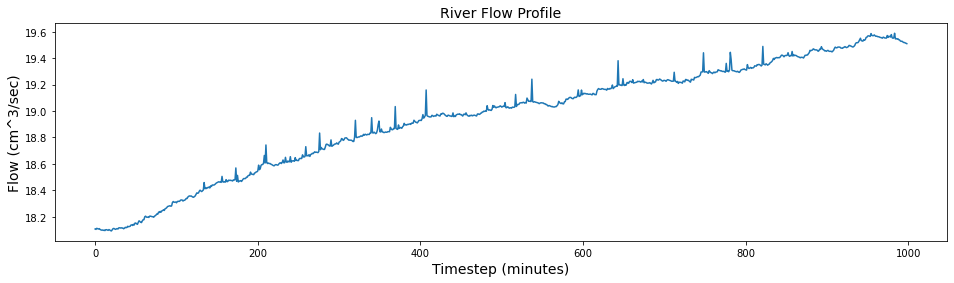

In [4]:
# plot the river flow

plt.figure(figsize=(16, 4))
plt.plot(F)

plt.xlabel('Timestep (minutes)', fontsize=14)
plt.ylabel('Flow (cm^3/sec)', fontsize=14)
plt.title('River Flow Profile', fontsize=14);
plt.show()

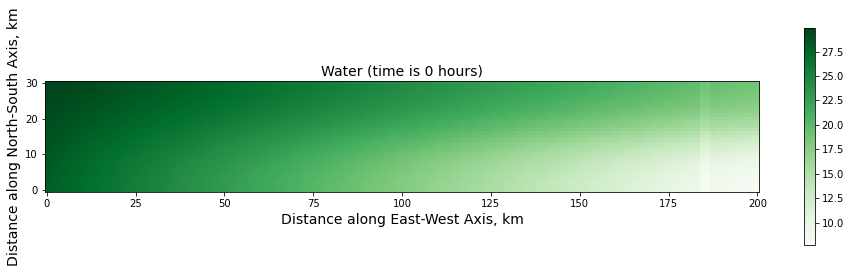

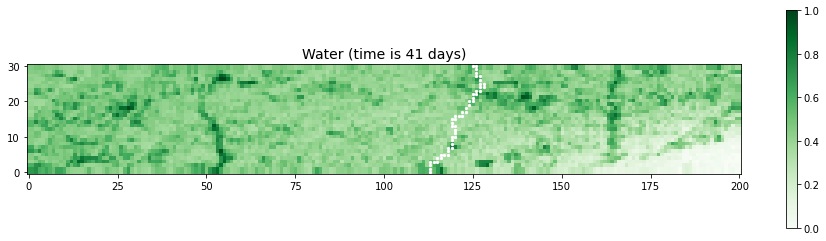

In [5]:
# Show before and after pictures from which analysis takes place

#initiate begin plot
plt.figure(figsize=(16, 4))
plt.imshow(W[:,:,0])
ax = plt.gca()
ax.invert_yaxis()

plt.xlabel('Distance along East-West Axis, km', fontsize=14)
plt.ylabel('Distance along North-South Axis, km', fontsize=14)
plt.title('Water (time is 0 hours)', fontsize=14);
plt.colorbar()
plt.show()

#initiate end plot
plt.figure(figsize=(16, 4))
plt.imshow(W[:,:,ntimes-1])
plt.scatter(river_y, river_x, color='white', s=5)
ax = plt.gca()
ax.invert_yaxis()

plt.title('Water (time is ' + str(math.floor(ntimes*dt/3600/24)) +  ' days)', fontsize=14);
plt.colorbar()
plt.show()

In [10]:
# Perform an additional analysis to compare the two cases

# use the after changes forestry image
im = Image.open(r"forested2.png")
lm = im.resize((201, 31))
lm.show()
i_width, i_height = im.size
# load the forest image pixels as data
px = im.load()

# forest cover data array
Forest2 = np.zeros([ny,nx])

#fill another Forest grid
for i in range(1, i_width-1): #march east to west
    for j in range(1, i_height-1): #march south to north
        x = math.floor(i*ny/i_width) #fit image width to data width
        y = math.floor(j*nx/i_height) #fit image height to data height
        if px[i, j][0]!=255: #amount of red channel
            if px[i, j][2]!=255: #amount of blue channel
                Forest2[x][y] = Forest2[x][y] + (px[i, j][1]/255) #amount 

# create a function for water diffusion:
def water2(k, i, j):
    result = W2[i,j,k-1] + Kh*(dt/dx**2)*(W2[i,j+1,k-1]-2*W2[i,j,k-1]+W2[i,j-1,k-1])
    result = result + Kv*(dt/dy**2)*(W2[i+1,j,k-1]-2*W2[i,j,k-1]+W2[i-1,j,k-1])
    return result

#W2 = np.zeros([ny,nx,ntimes])
#W2[:,:,0] = Winit

# run the second model by marching through time
def run_model(Forest, Flow):
    
    W2 = np.zeros([ny,nx,ntimes])
    W2[:,:,0] = Winit

    for t in range(1, ntimes):
        for i in range(1, ny-1): # march east to west
            for j in range(1, nx-1): # march south to north
                W2[i][j][t] = water2(t, i, j)                            # process water diffusion         
                W2[i][j][t] = W2[i][j][t] - 0.00005 *(255-Forest[i][j])  # process water evaporation
                if (W2[i][j][t] < 0):                       
                    W2[i][j][t] = 0
                #if (based on pixel value range - or pixel value)
                W2[i][j][t] = W2[i][j][t] + 0.00007*Forest[i][j]         # process respiration
                if random.random() < 0.10: # 10% chance of rain
                    p_rand = random.random()*200+10 # amount of rain if rained
                    W2[i][j][t] = W2[i][j][t] + Precip[i][j]/p_rand     # process precipitation

        # process river channel flow:
        flow_in = 0
        for w in range(0, len(river_x)): #calculate water contribution to river channel
            flow_in = flow_in + (W2[river_x[w],river_y[w],t]/len(river_x))
            p_avg = 0
            if(t>100):
                for m in range(0, 100):
                    p_avg = (p_avg + P[t-m])/100
            if(p_avg > 0):  # direct moving_average contribution from rain
                flow_in = flow_in + p_avg
        river_flow = flow_in
        Flow.append(river_flow)
            
        # reset border cases
        W2[0,:,t] = W2[1,:,t]
        W2[30,:,t]= W2[29,:,t]

        for i in range(0, ny):
           W2[i,0,t]  = W2[i,1,t]
           W2[i,200,t]= W2[i,199,t]
        
        if (t%24 == 0):
            print("Day: " + str(t/24))

F2 = []

run_model(Forest2, F2)

Day: 1.0
Day: 2.0
Day: 3.0
Day: 4.0
Day: 5.0
Day: 6.0
Day: 7.0
Day: 8.0
Day: 9.0
Day: 10.0
Day: 11.0
Day: 12.0
Day: 13.0
Day: 14.0
Day: 15.0
Day: 16.0
Day: 17.0
Day: 18.0
Day: 19.0
Day: 20.0
Day: 21.0
Day: 22.0
Day: 23.0
Day: 24.0
Day: 25.0
Day: 26.0
Day: 27.0
Day: 28.0
Day: 29.0
Day: 30.0
Day: 31.0
Day: 32.0
Day: 33.0
Day: 34.0
Day: 35.0
Day: 36.0
Day: 37.0
Day: 38.0
Day: 39.0
Day: 40.0
Day: 41.0


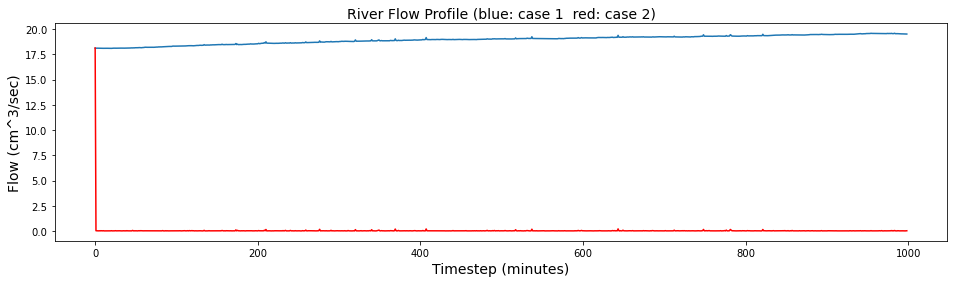

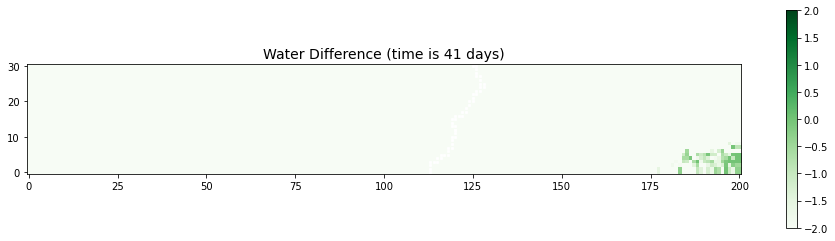

In [11]:
# plot the river flow

plt.figure(figsize=(16, 4))
plt.plot(F)
plt.plot(F2, color='red')

plt.xlabel('Timestep (minutes)', fontsize=14)
plt.ylabel('Flow (cm^3/sec)', fontsize=14)
plt.title('River Flow Profile (blue: case 1  red: case 2)', fontsize=14);
plt.show()

# Show after pictures from which analysis takes place

#difference in forest pixels water content
W3 = W2 - W

#initiate end plot
plt.figure(figsize=(16, 4))
plt.scatter(river_y, river_x, color='white', s=5)

plt.imshow(W3[:,:,ntimes-1], vmin=-2, vmax=2)
ax = plt.gca()
ax.invert_yaxis()

plt.title('Water Difference (time is ' + str(math.floor(ntimes*dt/3600/24)) +  ' days)', fontsize=14);
plt.colorbar()
plt.show()

In [ ]:
# To add to the analysis:

# 1. Show the depth of the river (quanity of water in the river)


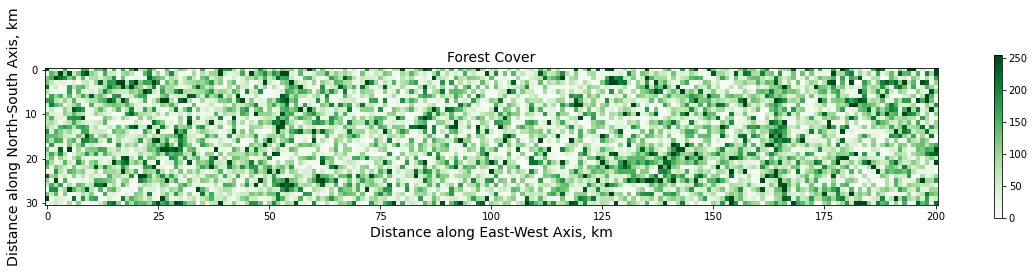

NameError: name 'run_model' is not defined

In [63]:
# Run a computer simulation of the user’s task

# Add 150% new forest:

total_forest = 0;
growth_ratio = 1.5

fill_forest_grid()

#sum the Forest grid
for i in range(1, nx-1): #march east to west
    for j in range(1, ny-1): #march south to north
        total_forest = total_forest + Forest[j][i]

new_forest = 0

import random

# grow it randomly
while (new_forest < total_forest * growth_ratio):
    rand_y = math.floor(random.random()*ny)
    rand_x = math.floor(random.random()*nx)
    forest_amt = Forest[rand_y][rand_x]
    Forest[rand_y][rand_x] = Forest[rand_y][rand_x] + random.random()*100 + 10
    if (Forest[rand_y][rand_x] > 255):
        Forest[rand_y][rand_x] = 255
    new_forest = new_forest + Forest[rand_y][rand_x] - forest_amt
    
plot_forest()

F3 = []

run_model(Forest, F3)

plt.figure(figsize=(16, 4))
plt.plot(F)
#plt.plot(F2, color='red')
plt.plot(F3, color='green')

plt.xlabel('Timestep (minutes)', fontsize=14)
plt.ylabel('Flow (cm^3/sec)', fontsize=14)
plt.title('River Flow Profile (blue: case 1  red: case 2  green: case 3)', fontsize=14);
plt.show()


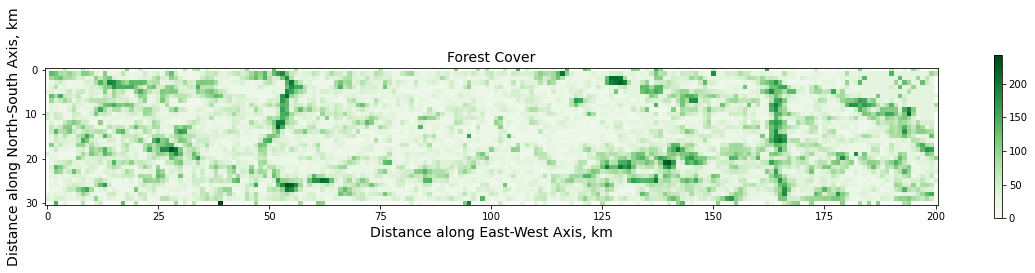

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.89757785 0.96059977 0.87793925 1.        ]
 [0.45176471 0.76708958 0.46120723 1.        ]
 [0.77922338 0.91323337 0.75180315 1.        ]
 [0.62929642 0.85001153 0.6061361  1.        ]
 [0.25259516 0.66812764 0.36286044 1.        ]
 [0.13402537 0.54232987 0.26828143 1.        ]
 [0.         0.42303729 0.17071895 1.        ]
 [0.         0.26666667 0.10588235 1.        ]]
1.1607843137254903
0.1607843137254903 0.8392156862745097
Day: 1.0
Day: 2.0
Day: 3.0
Day: 4.0
Day: 5.0
Day: 6.0
Day: 7.0
Day: 8.0
Day: 9.0
Day: 10.0
Day: 11.0
Day: 12.0
Day: 13.0
Day: 14.0
Day: 15.0
Day: 16.0
Day: 17.0
Day: 18.0
Day: 19.0
Day: 20.0
Day: 21.0
Day: 22.0
Day: 23.0
Day: 24.0
Day: 25.0
Day: 26.0
Day: 27.0
Day: 28.0
Day: 29.0
Day: 30.0
Day: 31.0
Day: 32.0
Day: 33.0
Day: 34.0
Day: 35.0
Day: 36.0
Day: 37.0
Day: 38.0
Day: 39.0
Day: 40.0
Day: 41.0


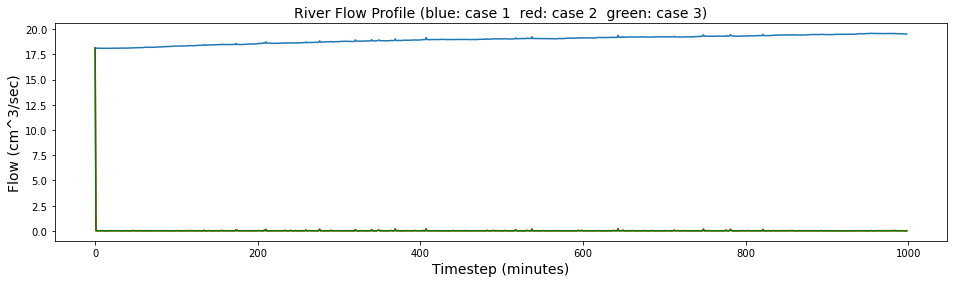

In [74]:
# grow it uniformly
fill_forest_grid()

#sum the Forest grid
for i in range(1, nx-1): #march east to west
    for j in range(1, ny-1): #march south to north
        Forest[j][i] = Forest[j][i] + (growth_ratio*total_forest)/(30*201)
    
plot_forest()

F4 = []

run_model(Forest, F4)

plt.figure(figsize=(16, 4))
plt.plot(F)
plt.plot(F2, color='red')
plt.plot(F4, color='green')

plt.xlabel('Timestep (minutes)', fontsize=14)
plt.ylabel('Flow (cm^3/sec)', fontsize=14)
plt.title('River Flow Profile (blue: case 1  red: case 2  green: case 3)', fontsize=14);
plt.show()


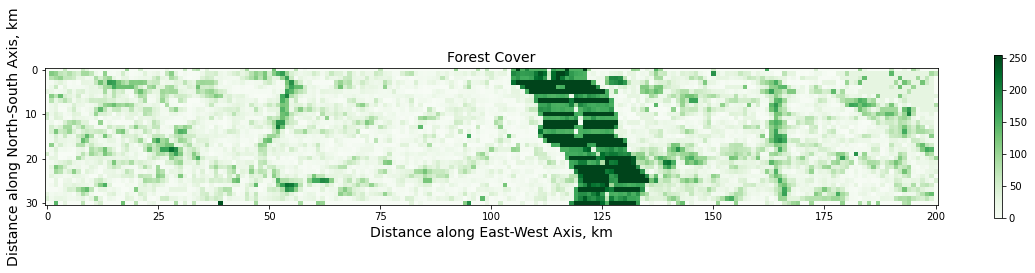

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.89757785 0.96059977 0.87793925 1.        ]
 [0.45176471 0.76708958 0.46120723 1.        ]
 [0.77922338 0.91323337 0.75180315 1.        ]
 [0.62929642 0.85001153 0.6061361  1.        ]
 [0.25259516 0.66812764 0.36286044 1.        ]
 [0.13402537 0.54232987 0.26828143 1.        ]
 [0.         0.42303729 0.17071895 1.        ]
 [0.         0.26666667 0.10588235 1.        ]]
0.6901960784313725
0.6901960784313725 0.30980392156862746


In [75]:
# grow it along the river

fill_forest_grid()

new_forest = 0
distance = 1
direction = 1
indx = 0

# grow it randomly
while (new_forest < total_forest * growth_ratio):
    forest_amt = Forest[river_x[indx]][river_y[indx]+distance*direction]
    Forest[river_x[indx]][river_y[indx]+distance*direction] = Forest[river_x[indx]][river_y[indx]+distance*direction] + 150
    if (Forest[river_x[indx]][river_y[indx]+distance*direction] > 255):
        Forest[river_x[indx]][river_y[indx]+distance*direction] = 255
    new_forest = new_forest + Forest[river_x[indx]][river_y[indx]+distance*direction] - forest_amt
    if (direction==1):
        direction = -1
    else:
        direction = 1
        if indx < (len(river_x)-1):
            indx = indx + 1
        else:
            indx = 0
            distance = distance + 1
            
plot_forest()

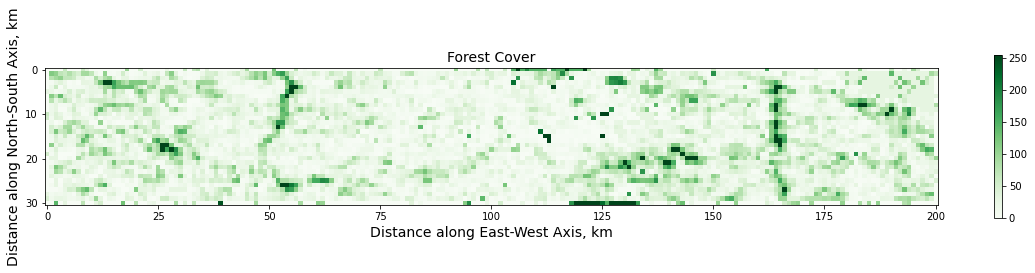

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.89757785 0.96059977 0.87793925 1.        ]
 [0.45176471 0.76708958 0.46120723 1.        ]
 [0.77922338 0.91323337 0.75180315 1.        ]
 [0.62929642 0.85001153 0.6061361  1.        ]
 [0.25259516 0.66812764 0.36286044 1.        ]
 [0.13402537 0.54232987 0.26828143 1.        ]
 [0.         0.42303729 0.17071895 1.        ]
 [0.         0.26666667 0.10588235 1.        ]]
0.6901960784313725
0.6901960784313725 0.30980392156862746


In [76]:
# grow existing forest clumps

fill_forest_grid()

new_forest = 0
x = 1
y = 1

# grow it randomly
while (new_forest < total_forest * growth_ratio):
    if (Forest[y][x] > 80):
        if (Forest[y-1][x] > 80):
            if (Forest[y][x-1] > 80):
                if (Forest[y+1][x] > 80):
                    if (Forest[y][x+1] > 80):
                        forest_amt = Forest[rand_y][rand_x]
                        Forest[y][x] = Forest[y][x] + random.random()*100 + 10
                        if (Forest[y][x] > 255):
                            Forest[y][x] = 255
                        new_forest = new_forest + Forest[y][x] - forest_amt
    x = x + 1
    if (x>nx-2):
        x = 1
        y = y + 1
        if (y>ny-2):
            y = 1
    
plot_forest()

# remove 50% old forest:

# random selection of forested pixels
# shrink existing forest clumps
# remove forest along the river

# Compare that to 200%

In [7]:
# Compare the computer simulation to the user’s choices through modeling and analysis

In [24]:
# Create a machine learning approach to predict whether the forestation actions came from a 
# human user or computer simulation

import os                       
import torch                    
import torch.nn as nn          
from torch.utils.data import DataLoader
from PIL import Image          
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid      
from torchvision.datasets import ImageFolder
from torchsummary import summary

data_dir = "input"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
gen_types = os.listdir(train_dir)

print(f"Unique Scenario Generation Types are: \n{gen_types}")

Unique Scenario Generation Types are: 
['user', 'computer']


In [25]:
scenarios = []
NumberOfGenTypes = 0
for scenario in gen_types:
    if scenario not in scenarios:
        scenarios.append(scenario)
        NumberOfGenTypes += 1

In [26]:
print("Number of Scenario Generation Types: {}".format(len(scenarios)))

Number of Scenario Generation Types: 2


In [27]:
import pandas as pd

nums = {}
for scenario in gen_types:
    nums[scenario] = len(os.listdir(train_dir + '/' + scenario))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
user,3
computer,4


In [28]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 7 images for training


In [29]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [30]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 31, 201]) 0


In [31]:
len(train.classes)

2

In [32]:
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

Matplotlib created a temporary config/cache directory at /var/folders/zf/49prmn_s7s5861rytkmr3_080000gn/T/matplotlib-2pdou4th because the default path (/Users/ribells/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Label :computer(0)


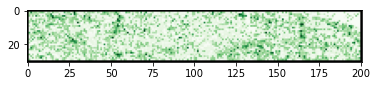

In [12]:
import matplotlib.pyplot as plt

show_image(*train[0])

In [33]:
random_seed = 7
batch_size = 32
torch.manual_seed(random_seed)

In [34]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [35]:
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

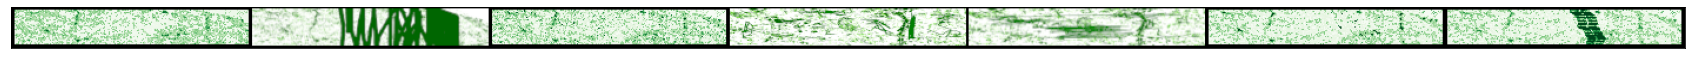

In [16]:
show_batch(train_dl)

In [36]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

#cuda not available on Mac OS X
device = torch.device("cpu")

device

device(type='cpu')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [38]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [39]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                 
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)          
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()      
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [40]:
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True)
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True)
        self.conv4 = ConvBlock(256, 512, pool=True)
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))       
    def forward(self, xb): 
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [41]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [54]:
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cpu(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [55]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [56]:
%%time
history = [evaluate(model, valid_dl)]
history

RuntimeError: Given input size: (512x1x12). Calculated output size: (512x0x3). Output size is too small

In [47]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [48]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

NameError: name 'history' is not defined

In [49]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [50]:
plot_accuracies(history)

NameError: name 'history' is not defined

In [51]:
plot_losses(history)

NameError: name 'history' is not defined

In [52]:
plot_lrs(history)

NameError: name 'history' is not defined